## Common Imports

In [75]:
import os
import soundfile as sf
import scipy.signal as ss
from scipy.io import wavfile
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings

## Common Functions

In [76]:
def get_channels(num_channels, lowcut, highcut, distr='linear'):
    """
    This function calculates channel widths for an array of filters
    
    Args:
        num_channels (int): desired number of channels
        lowcut (int): min frequency allowed (Hz)
        highcut (int): highest fequency allowed (Hz) 
        distr (str): the distribution that the channels will follow (one of: linear, log2, log10)
    
    Returns:
        freqs np.ndarray: an array of integers of all frequency bands
    """
    if distr == 'linear':
        freqs = np.linspace(lowcut, highcut, num_channels + 1)
    elif distr == 'log10':
        freqs = np.logspace(np.log10(lowcut), np.log10(highcut), num_channels + 1, endpoint=True, base=10.0)
    elif distr == 'log2':
        freqs = np.logspace(np.log2(lowcut), np.log2(highcut), num_channels + 1, endpoint=True, base=2.0)
    else:
        raise ValueError(f"Distribution: {distr} not implemented yet")
    
    clipped_freqs = np.clip(freqs, 0, 8000)
    
    return clipped_freqs

## Parks–McClellan Filter Functions

### Note on ntaps calc

In [77]:
def estimate_ntaps(transition_width, fs, attenuation_dB):
    """
    Estimates the number of taps for an FIR filter based on the transition width and desired attenuation.

    Args:
        transition_width (float): Transition width in Hz.
        fs (float): Sampling frequency in Hz.
        attenuation_dB (float): Desired stopband attenuation in dB.

    Returns:
        int: Estimated number of taps.
    """
    width = transition_width / (fs / 2)
    
    numtaps, beta = ss.kaiserord(attenuation_dB, width)
    
    return numtaps, beta
    

In [78]:
def get_desired(ftype):
    """
    gets the 'desired' array based on the filter type
    
    Args:
        type (str): the type of filter
        
    Returns:
        desired (array(int)): Desired gains (0 for stopbands, 1 for passbands)"""
        
    if ftype == 'lowpass':
        desired = [1, 0]
    elif ftype == 'bandpass':
        desired = [0, 1, 0]
    elif ftype == 'highpass':
        desired = [0, 1]
    else:
        raise ValueError(f"Filter type {ftype} not implemented yet")
    
    return desired

In [71]:
def pm_filters(num_channels, edges, ftype, fs, transition_percentage = 0.1, weight=None, max_iter=25, grid_density=16):
    """
    Creates a filter bank using the Parks–McClellan algorithm.

    Args:
        num_channels (int): Number of filters (channels) in the bank.
        edges (array_like): Sequence containing the band edges for all filters.
        ftype (str): Type of filter ('bandpass', 'differentiator', 'hilbert').
        fs (float): Sampling frequency.
        transition_percentage (float): percentage of the channel width used for transitioning to stop band
        weight (array_like, optional): Relative weighting for each band region.
        max_iter (int, optional): Maximum number of iterations of the algorithm. Default is 25.
        grid_density (int, optional): Grid density. Default is 16.

    Returns:
        list: A list containing the coefficients of the designed filters.
    """
    
    filters = []
    desired = get_desired(ftype)
    transition_percentage = transition_percentage  # 10% of the channel bandwidth
    attenuation_dB = 60  # dB
    
    for i in range(num_channels):
        # Calculate channel bandwidth
        lower_edge = edges[i]
        upper_edge = edges[i + 1]
        bandwidth = upper_edge - lower_edge

        # Calculate transition width
        transition_width = transition_percentage * bandwidth
        ntaps, beta = estimate_ntaps(transition_width, fs, attenuation_dB)

        # Define band edges with transition bands
        lower_stop = max(0, lower_edge - transition_width)
        lower_pass = lower_edge
        upper_pass = upper_edge
        upper_stop = min(fs / 2, upper_edge + transition_width)
        nyquist = fs / 2

        band_edges = [0, lower_stop, lower_pass, upper_pass, upper_stop, nyquist]
        
        # Apply the region weight if applicable
        if weight is not None:
            band_weight = weight[i]
        else:
            band_weight = None
        
        taps = ss.remez(
            numtaps=ntaps, 
            bands=band_edges, 
            desired=desired, 
            weight=band_weight, 
            fs=fs, 
            type=ftype, 
            maxiter=max_iter, 
            grid_density=grid_density)
        filters.append(taps)
        
    return filters

## Define PM Band Pass Filters

In [6]:
# Constants
FS = 16000
LOWCUT = 100
HIGHCUT = 8000
N = [8, 16, 22]

### PK Filters

1. N = 8, Dist = linear
2. N = 8, Dist = log2
3. N = 8, Dist = log10

1. N = 16, Dist = linear
2. N = 16, Dist = log2
3. N = 16, Dist = log10

1. N = 22, Dist = linear
2. N = 22, Dist = log2
3. N = 22, Dist = log10

In [7]:
def design_filter_bank(num_channels, edges, ftype, fs, transition_percentage=0.1, weight=None, max_iter=25, grid_density=16, min_transition=1e-6):
    """
    Recursively attempts to design a filter bank using the Parks–McClellan algorithm.
    If an error occurs, the transition width is reduced by half and retried.

    Args:
        num_channels (int): Number of filters (channels) in the bank.
        edges (array_like): Sequence containing the band edges for all filters.
        ftype (str): Type of filter ('bandpass', 'differentiator', 'hilbert').
        fs (float): Sampling frequency.
        transition_percentage (float): Percentage of the channel width used for transitioning to stop band.
        weight (array_like, optional): Relative weighting for each band region.
        max_iter (int, optional): Maximum number of iterations of the algorithm. Default is 25.
        grid_density (int, optional): Grid density. Default is 16.
        min_transition (float, optional): Minimum allowable transition width percentage to prevent infinite recursion.

    Returns:
        list: A list containing the coefficients of the designed filters.

    Raises:
        ValueError: If the transition width becomes too small to design a valid filter.
    """
    try:
        print(f"transition percentage {transition_percentage}")
        filters = pm_filters(
            num_channels=num_channels,
            edges=edges,
            ftype=ftype,
            fs=fs,
            transition_percentage=transition_percentage,
            weight=weight,
            max_iter=max_iter,
            grid_density=grid_density
        )
        return filters
    except ValueError as e:
        if 'reducing transition band width' in str(e).lower() and transition_percentage > min_transition:
            print(f"Convergence error: {e}. Reducing transition width and retrying...")
            return design_filter_bank(
                num_channels,
                edges,
                ftype,
                fs,
                transition_percentage=transition_percentage * 0.9,
                weight=weight,
                max_iter=max_iter,
                grid_density=grid_density,
                min_transition=min_transition
            )
        else:
            raise ValueError(f"Failed to design filter bank: {e}")


In [8]:
pm_banks = {}  # Initialize the dictionary to store filter banks
initial_transition_percentage = 0.1  # Starting transition width percentage

for num_channels in N:
    for distr in ['linear', 'log2', 'log10']:
        print(f"Iter {num_channels, distr}")
        
        # Calculate channel edges
        edges = get_channels(num_channels, LOWCUT, HIGHCUT, distr=distr)
        
        # Design filter bank with recursive error handling
        ftype = 'bandpass'  # Filter type
        try:
            filters = design_filter_bank(
                num_channels=num_channels,
                edges=edges,
                ftype=ftype,
                fs=FS,
                transition_percentage=initial_transition_percentage
            )
            pm_bank_key = f"{num_channels}_{distr}"
            pm_banks[pm_bank_key] = filters
            print(f"Filter bank '{pm_bank_key}' designed successfully.")
        except ValueError as e:
            print(f"Error designing filter bank '{num_channels}_{distr}': {e}")


Iter (8, 'linear')
transition percentage 0.1
Filter bank '8_linear' designed successfully.
Iter (8, 'log2')
transition percentage 0.1
Convergence error: Failure to converge at iteration 11, try reducing transition band width.
. Reducing transition width and retrying...
new transition percentage 0.09000000000000001
transition percentage 0.09000000000000001
Filter bank '8_log2' designed successfully.
Iter (8, 'log10')
transition percentage 0.1
Convergence error: Failure to converge at iteration 11, try reducing transition band width.
. Reducing transition width and retrying...
new transition percentage 0.09000000000000001
transition percentage 0.09000000000000001
Filter bank '8_log10' designed successfully.
Iter (16, 'linear')
transition percentage 0.1
Convergence error: Failure to converge at iteration 13, try reducing transition band width.
. Reducing transition width and retrying...
new transition percentage 0.09000000000000001
transition percentage 0.09000000000000001
Filter bank '16

In [12]:
import pickle
import os

directory = 'pm_params'
file_path = os.path.join(directory, 'pm_banks.pkl')

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Write the object to the file
with open(file_path, 'wb') as file:
    pickle.dump(pm_banks, file)

## Non PM Filters Designs

In [79]:
def design_butter_bank(num_channels, edges, fs, order=4):
    """
    Design a bank of bandpass Butterworth filters.

    Args:
        num_channels (int): Number of filters (channels) in the bank.
        edges (array_like): Sequence containing the band edges for all filters.
        fs (float): Sampling frequency in Hz.
        order (int): Order of the Butterworth filter.

    Returns:
        list: A list containing the filter coefficients (b, a) for each bandpass filter.
    """
    filters = []
    nyquist = fs / 2.0

    for i in range(num_channels):
        low = edges[i] / nyquist
        high = edges[i + 1] / nyquist

        if low <= 0:
            low = 0.001  # Avoid zero frequency
        if high >= 1:
            high = 0.999  # Avoid Nyquist frequency

        b, a = ss.butter(order, [low, high], btype='band')
        filters.append((b, a))

    return filters

In [80]:
# Parameters
N = [8, 16, 32]  # List of number of channels
LOWCUT = 100.0   # Lower frequency bound in Hz
HIGHCUT = 8000.0 # Upper frequency bound in Hz
FS = 16000.0     # Sampling frequency in Hz
ORDER = 4        # Order of the Butterworth filter

butter_banks = {}  # Initialize the dictionary to store filter banks

for num_channels in N:
    for distr in ['linear', 'log2', 'log10']:
        print(f"Designing filter bank with {num_channels} channels using {distr} distribution.")
        
        # Calculate channel edges
        edges = get_channels(num_channels, LOWCUT, HIGHCUT, distr=distr)
        
        # Design filter bank
        try:
            filters = design_butter_bank(
                num_channels=num_channels,
                edges=edges,
                fs=FS,
                order=ORDER
            )
            butter_bank_key = f"{num_channels}_{distr}"
            butter_banks[butter_bank_key] = filters
            print(f"Filter bank '{filter_bank_key}' designed successfully.")
        except ValueError as e:
            print(f"Error designing filter bank '{butter_bank_key}': {e}")

Designing filter bank with 8 channels using linear distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 8 channels using log2 distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 8 channels using log10 distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 16 channels using linear distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 16 channels using log2 distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 16 channels using log10 distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 32 channels using linear distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 32 channels using log2 distribution.
Filter bank '32_log10' designed successfully.
Designing filter bank with 32 channels using log10 distribution.
Filter bank '32_log10' designed successfully.


In [81]:
directory = 'butter_params'
file_path = os.path.join(directory, 'butter_banks.pkl')

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Write the object to the file
with open(file_path, 'wb') as file:
    pickle.dump(butter_banks, file)

In [82]:
def design_gammatone_filter_bank(num_channels, edges, fs, ftype='iir'):
    """
    Design a bank of gammatone filters.

    Args:
        num_channels (int): Number of filters (channels) in the bank.
        edges (array_like): Sequence containing the band edges for all filters.
        fs (float): Sampling frequency in Hz.
        ftype (str): Type of filter ('fir' or 'iir').

    Returns:
        list: A list containing the filter coefficients (b, a) for each gammatone filter.
    """
    filters = []

    for i in range(num_channels):
        center_freq = (edges[i] + edges[i + 1]) / 2.0
        b, a = ss.gammatone(center_freq, ftype=ftype, fs=fs)
        filters.append((b, a))

    return filters

In [83]:
# Parameters
N = [8, 16, 32]  # List of number of channels
LOWCUT = 100.0   # Lower frequency bound in Hz
HIGHCUT = 8000.0 # Upper frequency bound in Hz
FS = 16000.0     # Sampling frequency in Hz
FTYPE = 'iir'    # Filter type ('fir' or 'iir')

gamma_banks = {}  # Initialize the dictionary to store filter banks

for num_channels in N:
    for distr in ['linear', 'log2', 'log10']:
        print(f"Designing gammatone filter bank with {num_channels} channels using {distr} distribution.")
        
        # Calculate channel edges
        edges = get_channels(num_channels, LOWCUT, HIGHCUT, distr=distr)
        
        # Design gammatone filter bank
        try:
            filters = design_gammatone_filter_bank(
                num_channels=num_channels,
                edges=edges,
                fs=FS,
                ftype=FTYPE
            )
            gamma_bank_key = f"{num_channels}_{distr}"
            gamma_banks[gamma_bank_key] = filters
            print(f"Gammatone filter bank '{gamma_bank_key}' designed successfully.")
        except ValueError as e:
            print(f"Error designing gammatone filter bank '{gamma_bank_key}': {e}")

Designing gammatone filter bank with 8 channels using linear distribution.
Gammatone filter bank '8_linear' designed successfully.
Designing gammatone filter bank with 8 channels using log2 distribution.
Gammatone filter bank '8_log2' designed successfully.
Designing gammatone filter bank with 8 channels using log10 distribution.
Gammatone filter bank '8_log10' designed successfully.
Designing gammatone filter bank with 16 channels using linear distribution.
Gammatone filter bank '16_linear' designed successfully.
Designing gammatone filter bank with 16 channels using log2 distribution.
Gammatone filter bank '16_log2' designed successfully.
Designing gammatone filter bank with 16 channels using log10 distribution.
Gammatone filter bank '16_log10' designed successfully.
Designing gammatone filter bank with 32 channels using linear distribution.
Gammatone filter bank '32_linear' designed successfully.
Designing gammatone filter bank with 32 channels using log2 distribution.
Gammatone fil

In [84]:
directory = 'gamma_params'
file_path = os.path.join(directory, 'gamma_banks.pkl')

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Write the object to the file
with open(file_path, 'wb') as file:
    pickle.dump(gamma_banks, file)

## Apply the filters to the audio signals

In [93]:
# define the data dir
current_dir = os.getcwd()
base_dir = os.path.dirname(current_dir)
data_dir = os.path.join(base_dir, 'data')
cleaned_data_dir = os.path.join(base_dir, 'data', 'cleaned_dataset')
data_subdir_names = ['ChildrenAudio', 'MaleFemaleAudio', 'NoisyAudio', 'MultipleSpeakers']
cleaned_data_subdir_paths = []

for name in data_subdir_names:
    cleaned_data_subdir_paths.append(os.path.join(cleaned_data_dir, name))

In [86]:
# load the filter params from the pkl file
with open('pm_params/pm_banks.pkl', 'rb') as file:
    pm_banks = pickle.load(file)

In [74]:
def process_and_display_pm_plot(cleaned_data_subdir_paths, filter_banks, max_files=5):
    for subdir in cleaned_data_subdir_paths:
        file_count = 0
        for root, dirs, files in os.walk(subdir):
            for file in files:
                if file.lower().endswith('.wav'):
                    file_path = os.path.join(root, file)
                    
                    # Load the audio file
                    sample_rate, audio_signal = wavfile.read(file_path)
                    
                    # Plot the original audio signal
                    plt.figure(figsize=(12, 4))
                    plt.plot(audio_signal, color='blue')
                    plt.title('Original Audio Signal')
                    plt.xlabel('Sample Index')
                    plt.ylabel('Amplitude')
                    plt.grid()
                    plt.show()
                    
                    # Ensure the audio is mono
                    if audio_signal.ndim == 2:
                        audio_signal = audio_signal.mean(axis=1)
                    
                    # Apply each filter bank
                    for bank_key, filters in filter_banks.items():
                        print(f"Applying filter bank: {bank_key} to file: {file}")
                        filtered_signals = []
                        for i, taps in enumerate(filters):
                            filtered_signal = ss.lfilter(taps, 1.0, audio_signal)
                            filtered_signals.append(filtered_signal)
                        
                        # Sum the filtered signals to reconstruct the signal
                        reconstructed_signal = np.sum(filtered_signals, axis=0)
                        
                        # Normalize the reconstructed signal for playback
                        #reconstructed_signal = np.int16(reconstructed_signal / np.max(np.abs(reconstructed_signal)) * 32767)
                        
                        # Display the reconstructed audio
                        print(f"Reconstructed Audio for filter bank '{bank_key}' and file: {file}")
                        # Plot the reconstructed audio signal
                        plt.figure(figsize=(12, 4))
                        plt.plot(reconstructed_signal, color='green')
                        plt.title(f'Reconstructed Audio Signal using Filter Bank: {bank_key}')
                        plt.xlabel('Sample Index')
                        plt.ylabel('Normalized Amplitude')
                        plt.grid()
                        plt.show()
                    
                    file_count += 1
                    if file_count >= max_files:
                        break  # Stop after processing 'max_files' files
            if file_count >= max_files:
                break  # Stop after processing 'max_files' files from this subdirectory
        print(f"Processed {file_count} audio files from {subdir}")

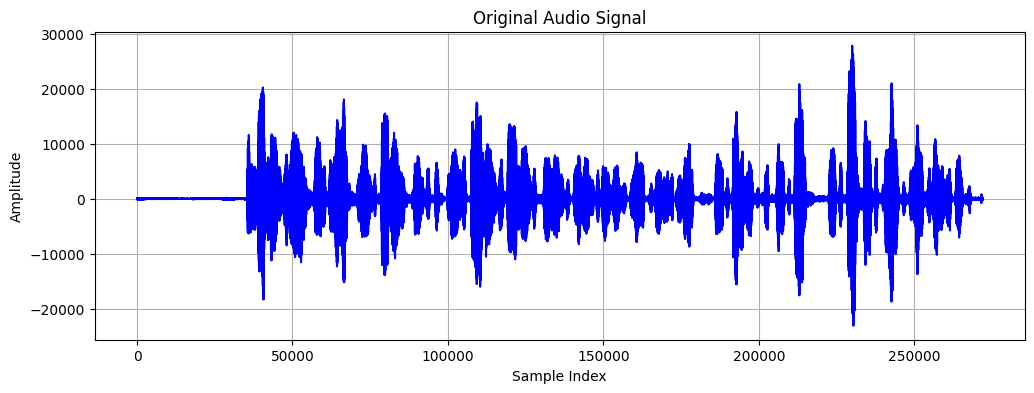

Applying filter bank: 8_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_linear' and file: F12_09_05.wav


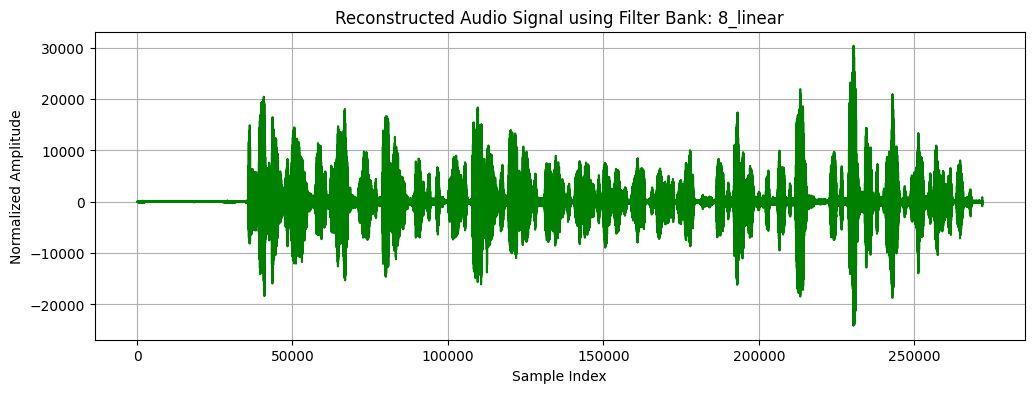

Applying filter bank: 8_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_log2' and file: F12_09_05.wav


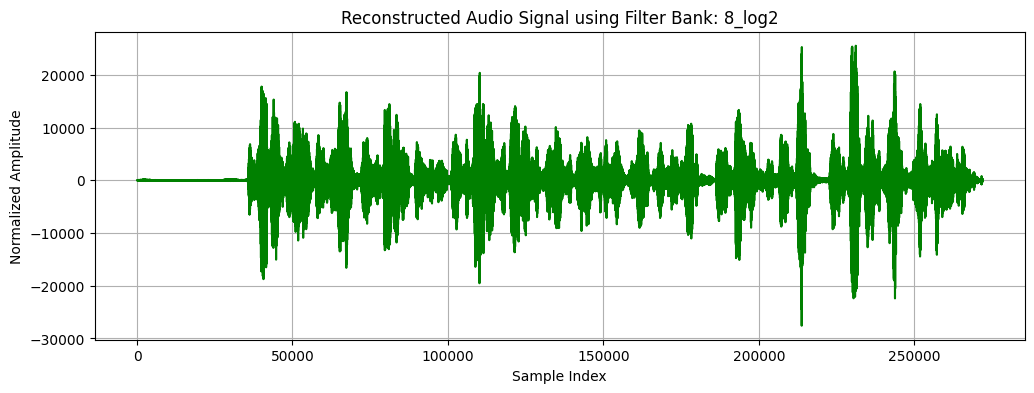

Applying filter bank: 8_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_log10' and file: F12_09_05.wav


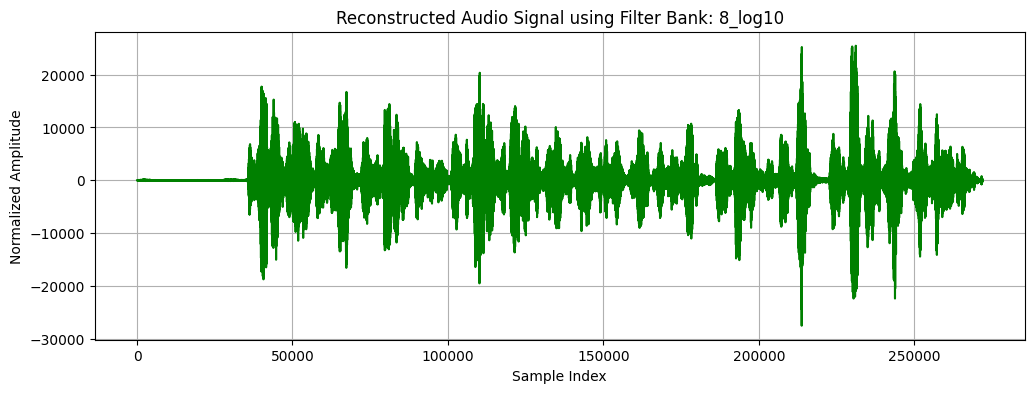

Applying filter bank: 16_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_linear' and file: F12_09_05.wav


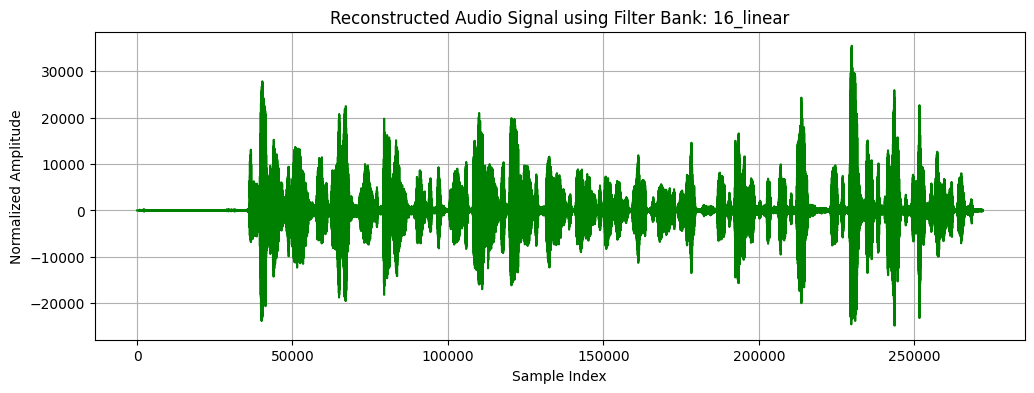

Applying filter bank: 16_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_log2' and file: F12_09_05.wav


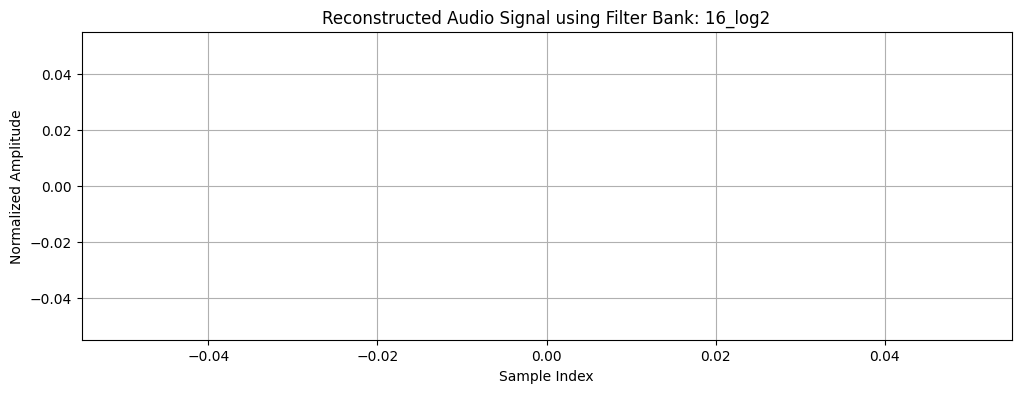

Applying filter bank: 16_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_log10' and file: F12_09_05.wav


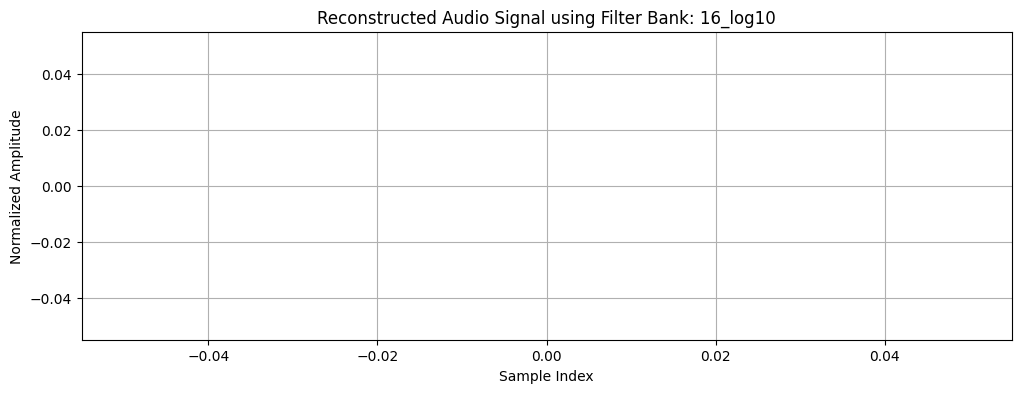

Applying filter bank: 22_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '22_linear' and file: F12_09_05.wav


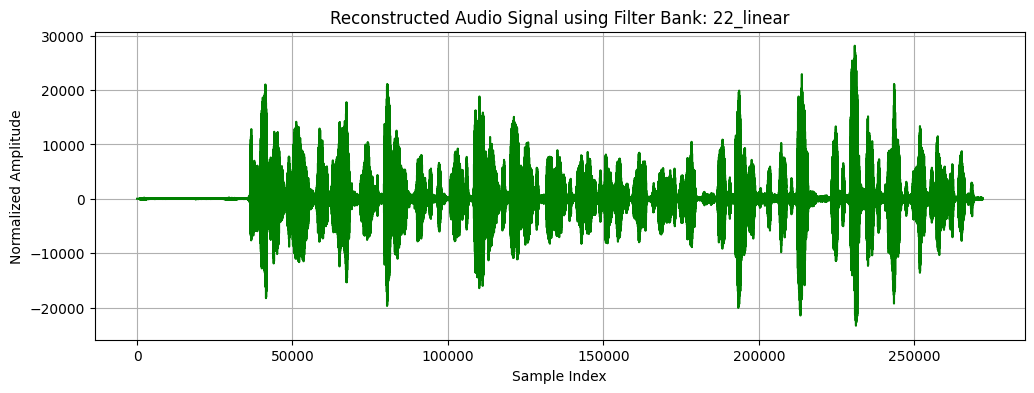

Applying filter bank: 22_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '22_log2' and file: F12_09_05.wav


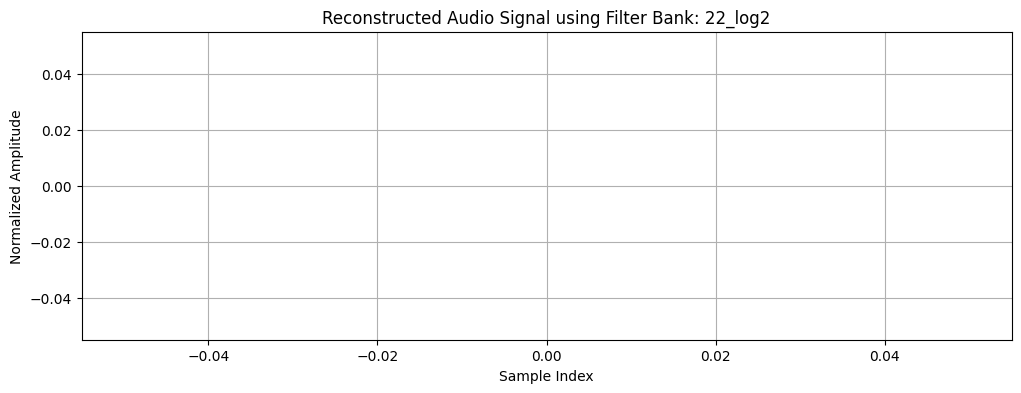

Applying filter bank: 22_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '22_log10' and file: F12_09_05.wav


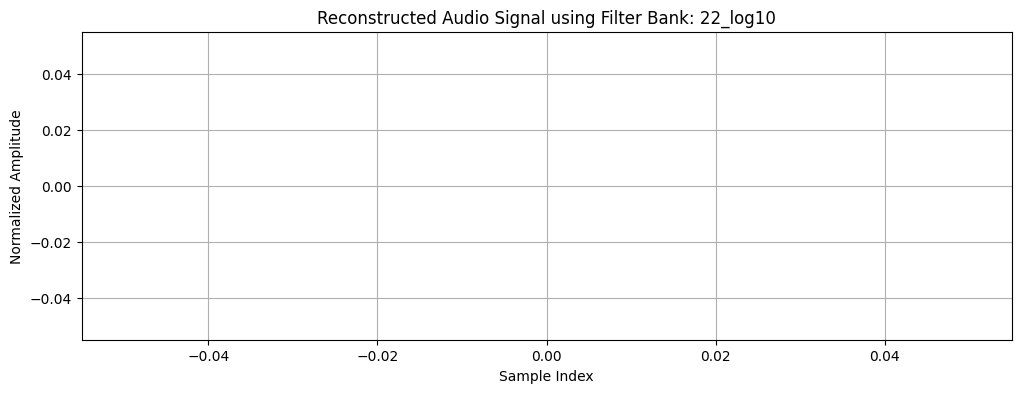

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/ChildrenAudio


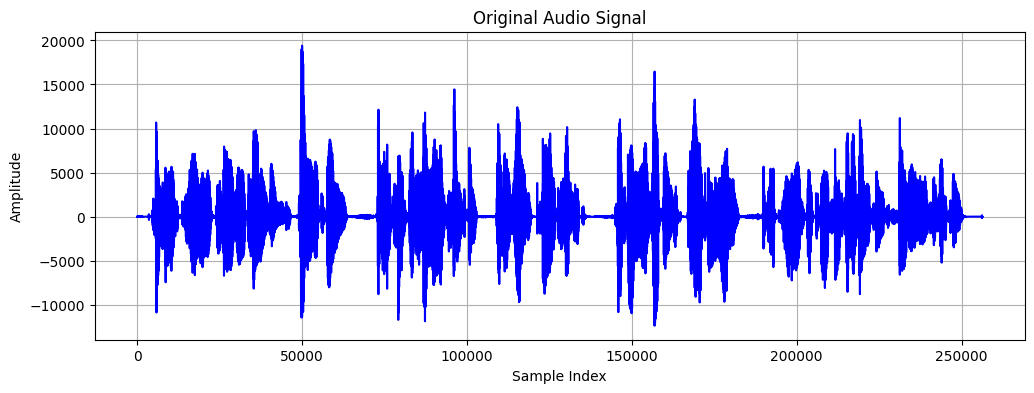

Applying filter bank: 8_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_linear' and file: male_3000_3000-15664-0020.wav


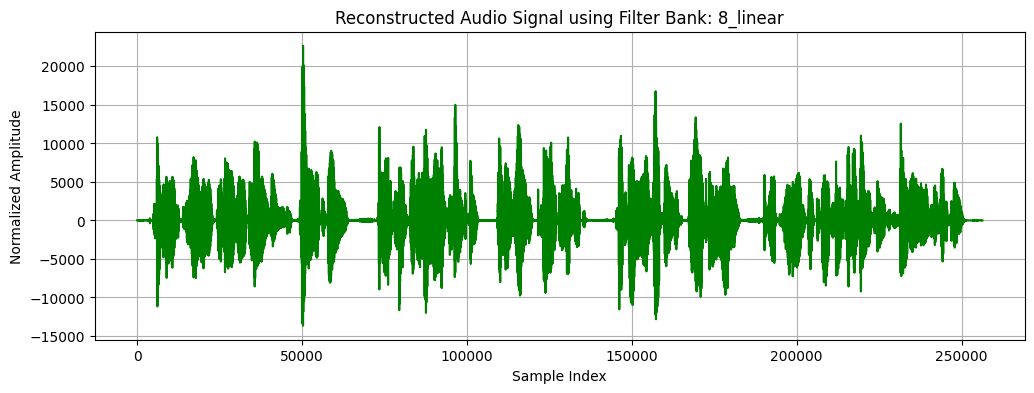

Applying filter bank: 8_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_log2' and file: male_3000_3000-15664-0020.wav


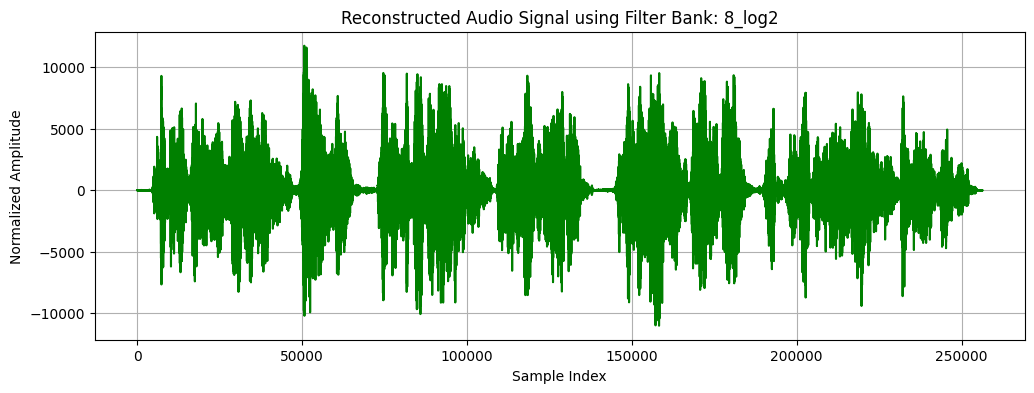

Applying filter bank: 8_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_log10' and file: male_3000_3000-15664-0020.wav


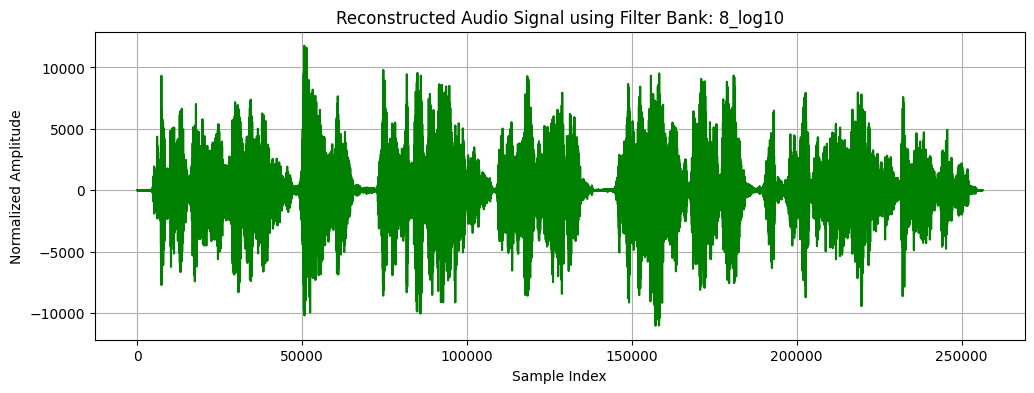

Applying filter bank: 16_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_linear' and file: male_3000_3000-15664-0020.wav


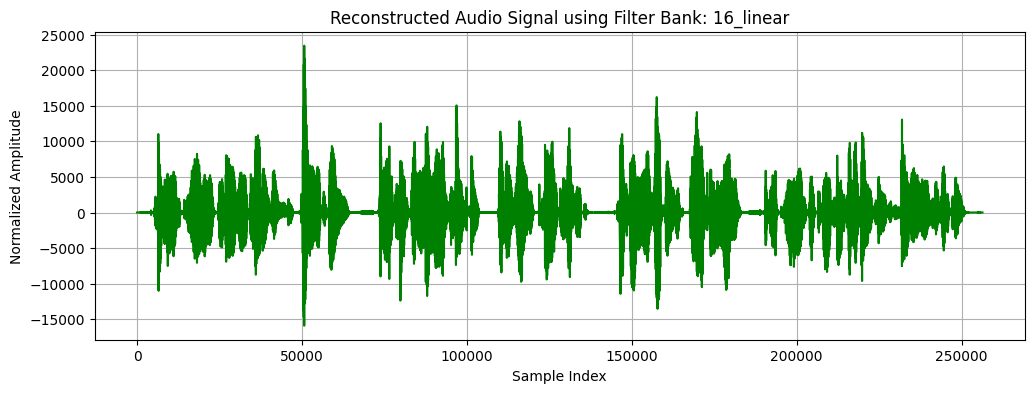

Applying filter bank: 16_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_log2' and file: male_3000_3000-15664-0020.wav


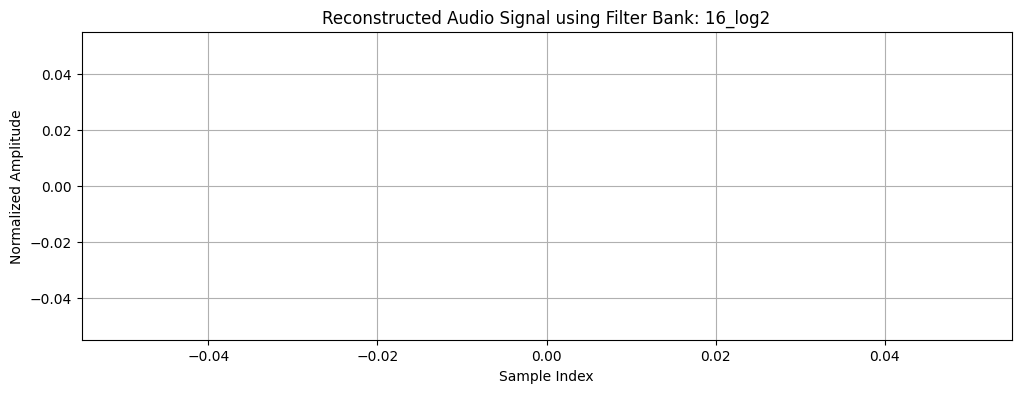

Applying filter bank: 16_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_log10' and file: male_3000_3000-15664-0020.wav


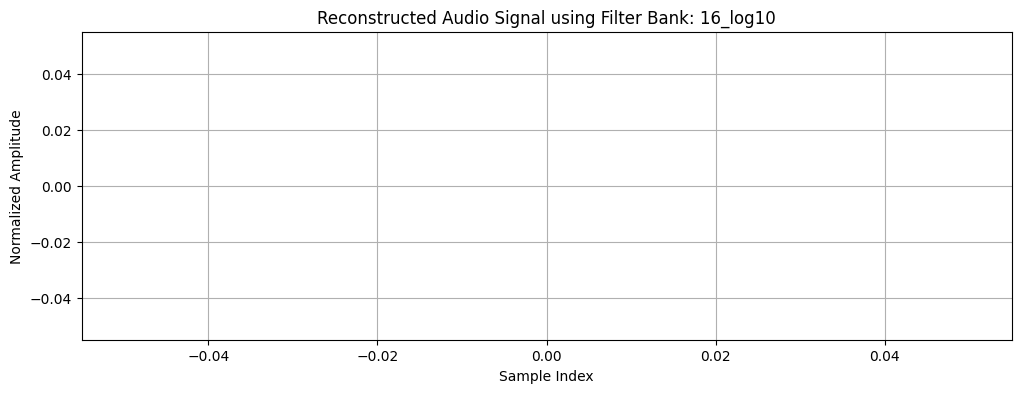

Applying filter bank: 22_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '22_linear' and file: male_3000_3000-15664-0020.wav


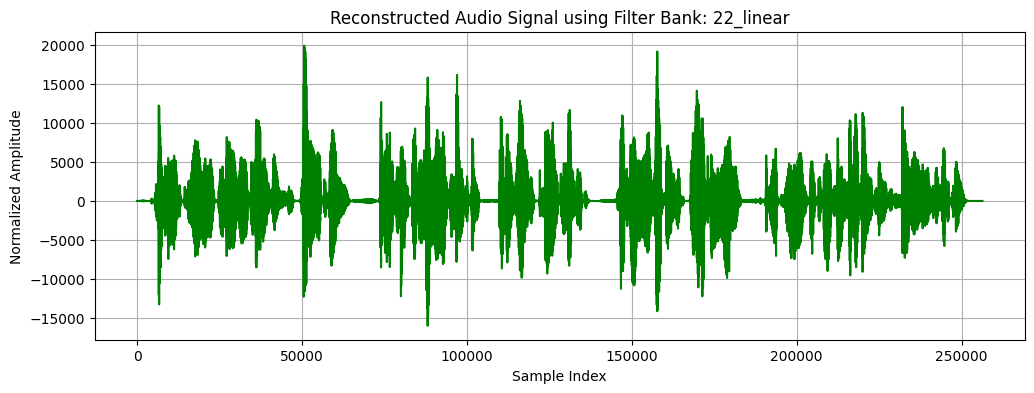

Applying filter bank: 22_log2 to file: male_3000_3000-15664-0020.wav


KeyboardInterrupt: 

In [63]:
process_and_display_pm_plot(cleaned_data_subdir_paths, pm_banks, max_files=0)

In [90]:
def process_and_display_plot(cleaned_data_subdir_paths, filter_banks, max_files=5):
    for subdir in cleaned_data_subdir_paths:
        file_count = 0
        for root, dirs, files in os.walk(subdir):
            for file in files:
                if file.lower().endswith('.wav'):
                    file_path = os.path.join(root, file)
                    
                    # Load the audio file
                    sample_rate, audio_signal = wavfile.read(file_path)
                    
                    # Plot the original audio signal
                    plt.figure(figsize=(12, 4))
                    plt.plot(audio_signal, color='blue')
                    plt.title('Original Audio Signal')
                    plt.xlabel('Sample Index')
                    plt.ylabel('Amplitude')
                    plt.grid()
                    plt.show()
                    
                    # Ensure the audio is mono
                    if audio_signal.ndim == 2:
                        audio_signal = audio_signal.mean(axis=1)
                    
                    # Apply each filter bank
                    for bank_key, filters in filter_banks.items():
                        print(f"Applying filter bank: {bank_key} to file: {file}")
                        filtered_signals = []
                        for i, (b, a) in enumerate(filters):
                            filtered_signal = ss.lfilter(b, a, audio_signal)
                            filtered_signals.append(filtered_signal)
                        
                        # Sum the filtered signals to reconstruct the signal
                        reconstructed_signal = np.sum(filtered_signals, axis=0)
                        
                        # Normalize the reconstructed signal for playback
                        #reconstructed_signal = np.int16(reconstructed_signal / np.max(np.abs(reconstructed_signal)) * 32767)
                        
                        # Display the reconstructed audio
                        print(f"Reconstructed Audio for filter bank '{bank_key}' and file: {file}")
                        # Plot the reconstructed audio signal
                        plt.figure(figsize=(12, 4))
                        plt.plot(reconstructed_signal, color='green')
                        plt.title(f'Reconstructed Audio Signal using Filter Bank: {bank_key}')
                        plt.xlabel('Sample Index')
                        plt.ylabel('Normalized Amplitude')
                        plt.grid()
                        plt.show()
                    
                    file_count += 1
                    if file_count >= max_files:
                        break  # Stop after processing 'max_files' files
            if file_count >= max_files:
                break  # Stop after processing 'max_files' files from this subdirectory
        print(f"Processed {file_count} audio files from {subdir}")

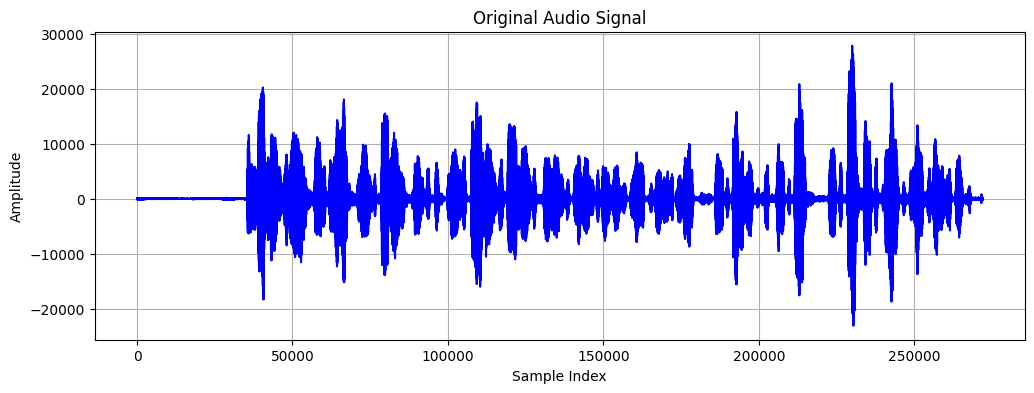

Applying filter bank: 8_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_linear' and file: F12_09_05.wav


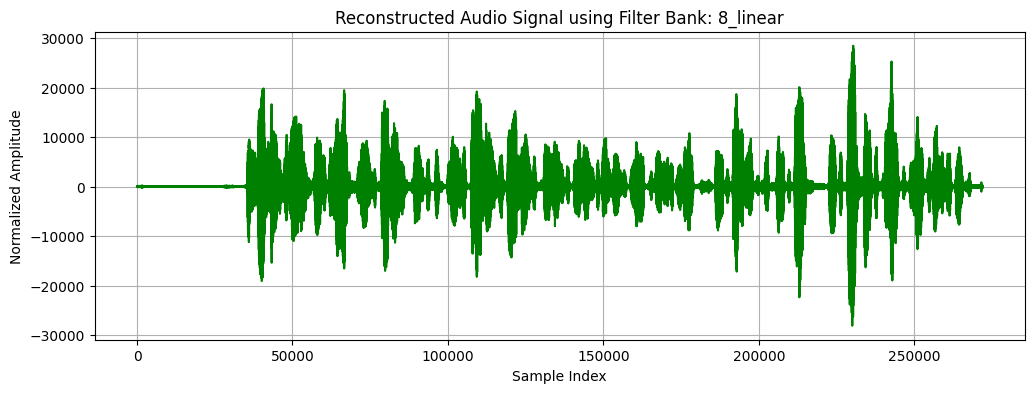

Applying filter bank: 8_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_log2' and file: F12_09_05.wav


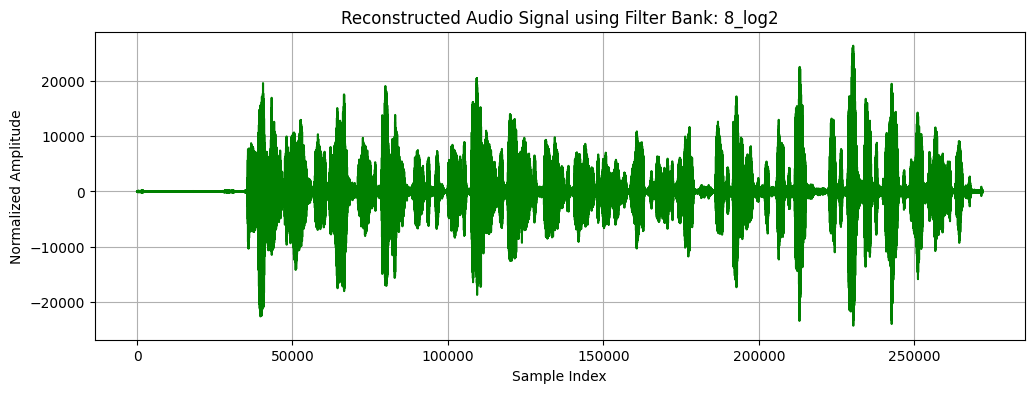

Applying filter bank: 8_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_log10' and file: F12_09_05.wav


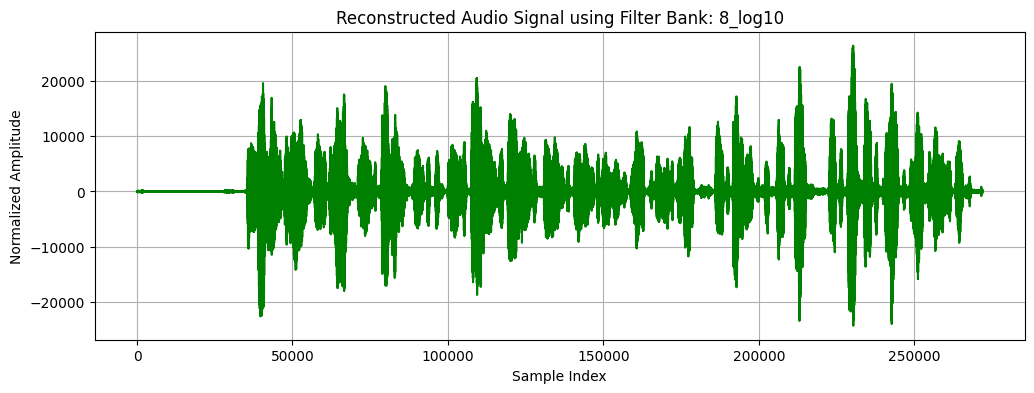

Applying filter bank: 16_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_linear' and file: F12_09_05.wav


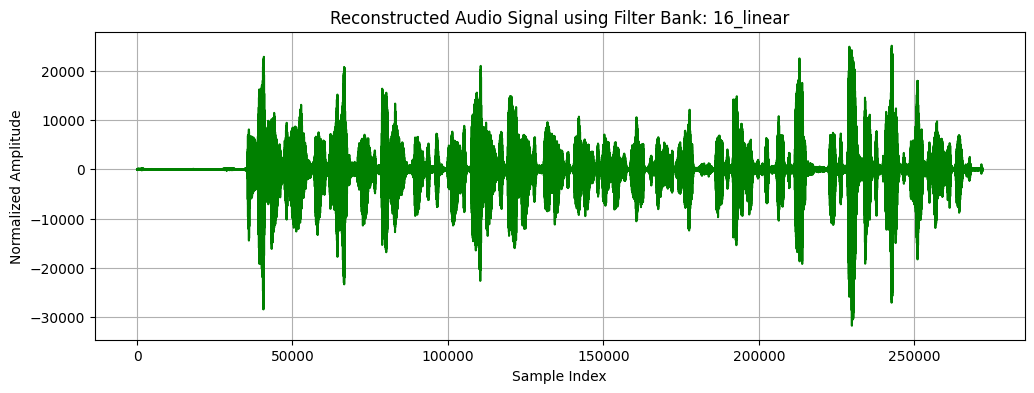

Applying filter bank: 16_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_log2' and file: F12_09_05.wav


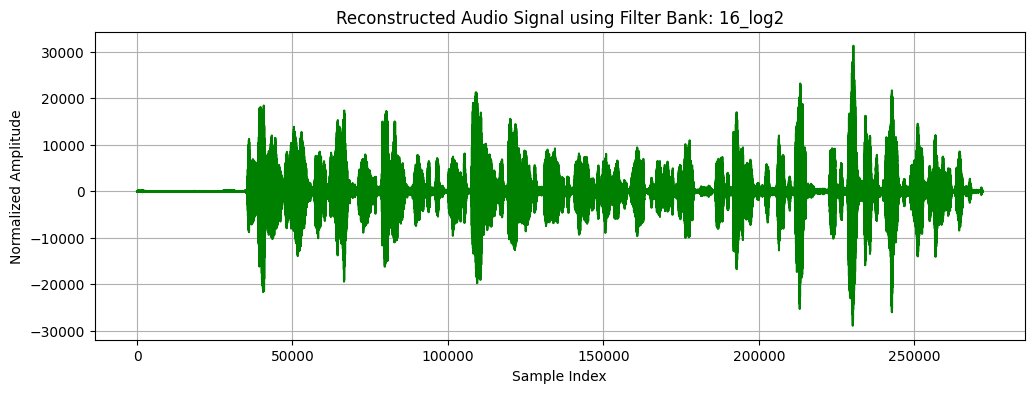

Applying filter bank: 16_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_log10' and file: F12_09_05.wav


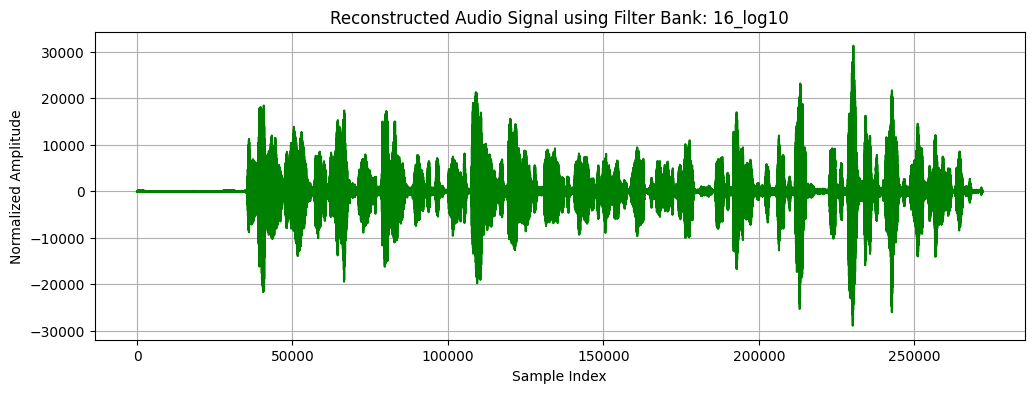

Applying filter bank: 32_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '32_linear' and file: F12_09_05.wav


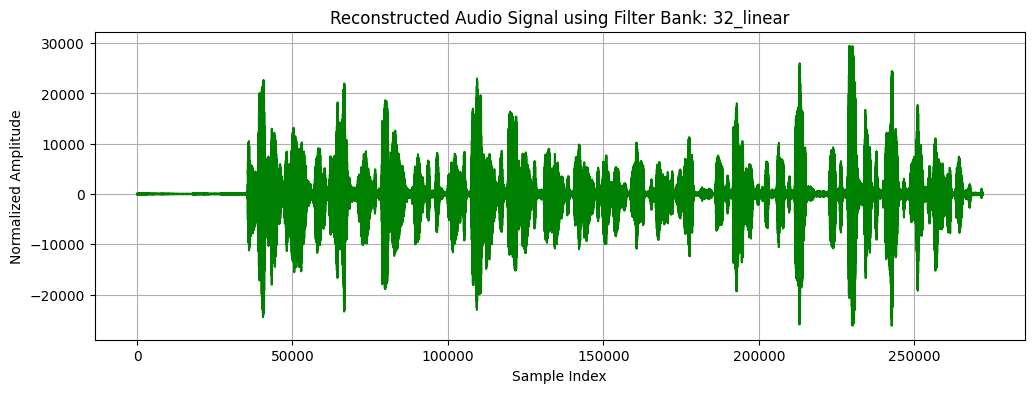

Applying filter bank: 32_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '32_log2' and file: F12_09_05.wav


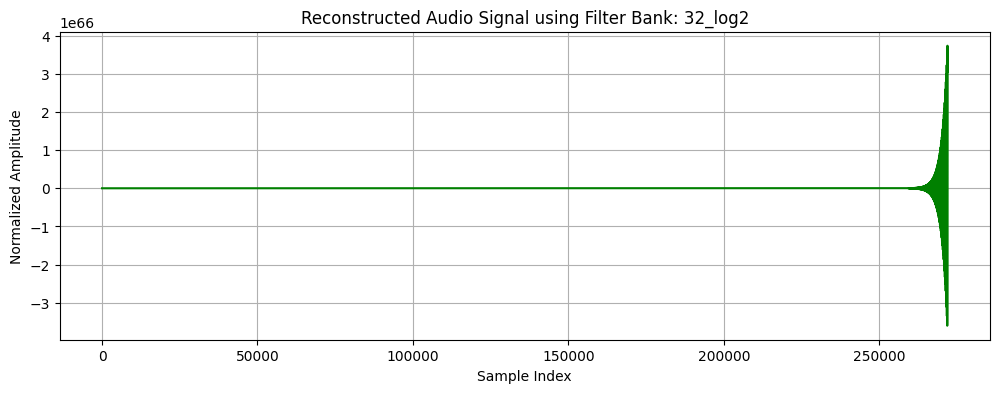

Applying filter bank: 32_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '32_log10' and file: F12_09_05.wav


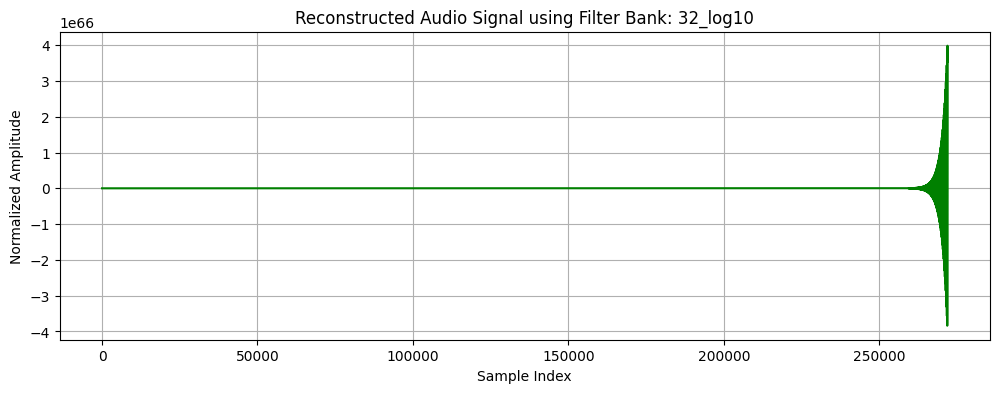

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/ChildrenAudio


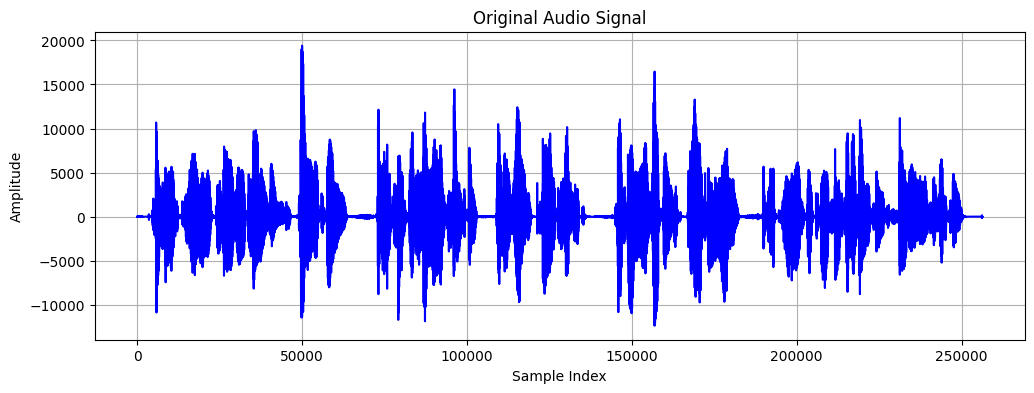

Applying filter bank: 8_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_linear' and file: male_3000_3000-15664-0020.wav


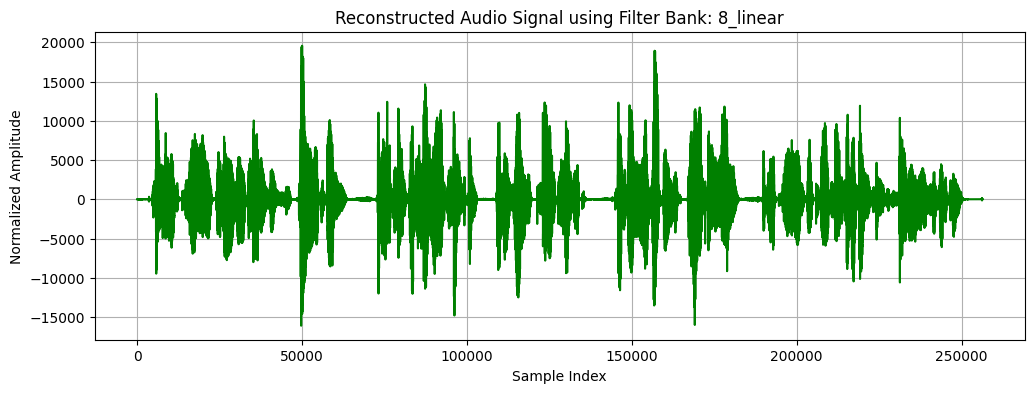

Applying filter bank: 8_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_log2' and file: male_3000_3000-15664-0020.wav


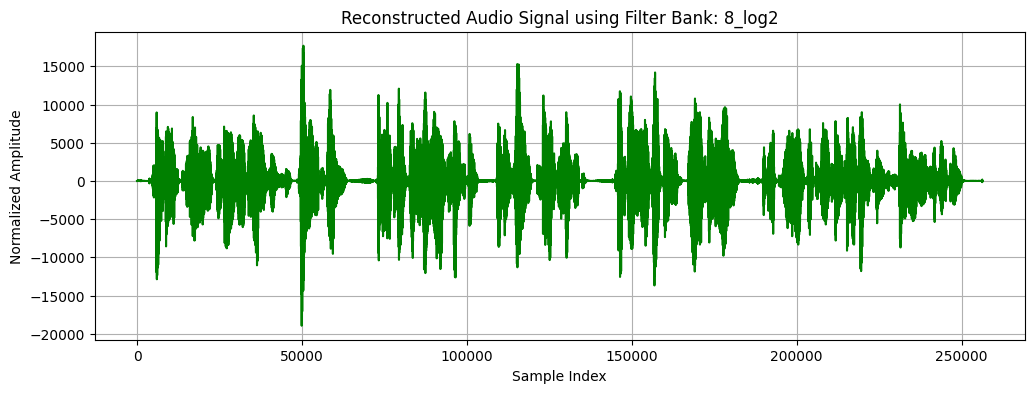

Applying filter bank: 8_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_log10' and file: male_3000_3000-15664-0020.wav


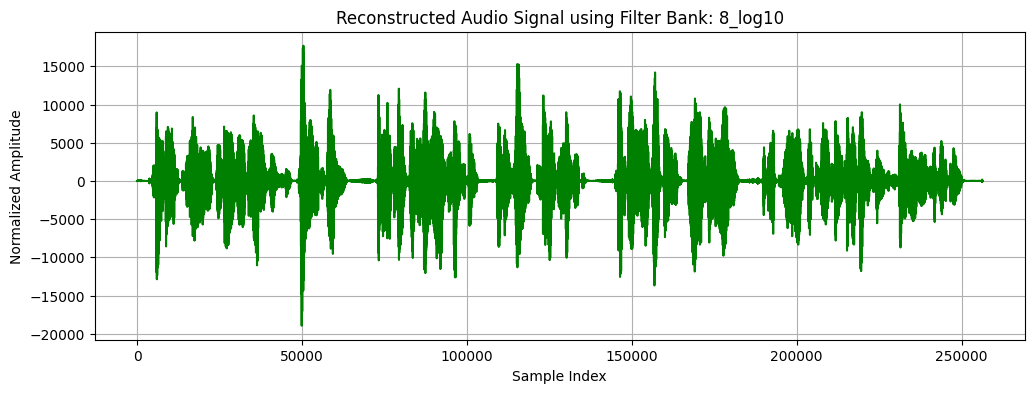

Applying filter bank: 16_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_linear' and file: male_3000_3000-15664-0020.wav


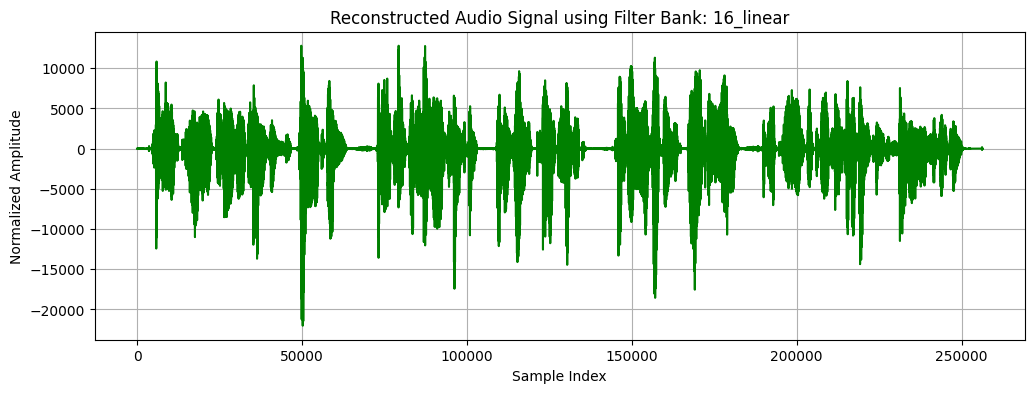

Applying filter bank: 16_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_log2' and file: male_3000_3000-15664-0020.wav


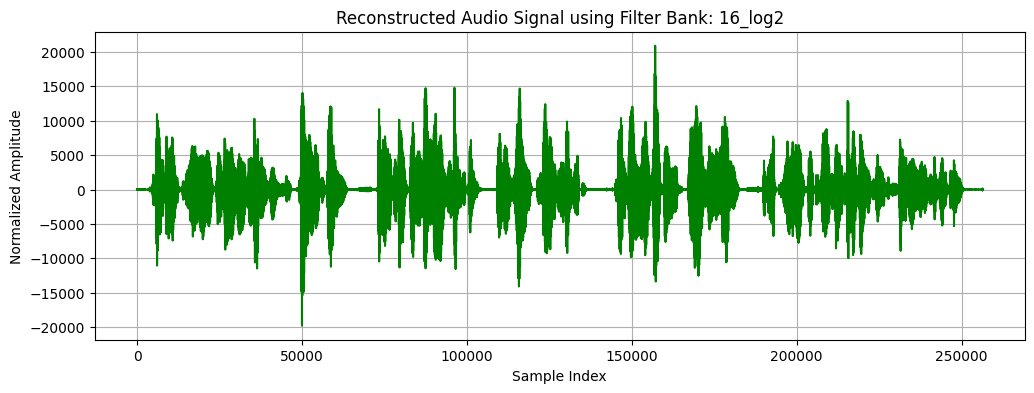

Applying filter bank: 16_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_log10' and file: male_3000_3000-15664-0020.wav


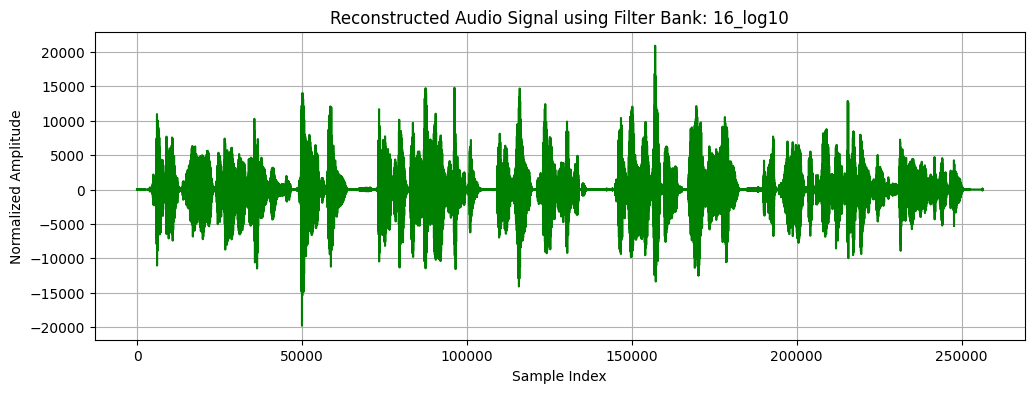

Applying filter bank: 32_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '32_linear' and file: male_3000_3000-15664-0020.wav


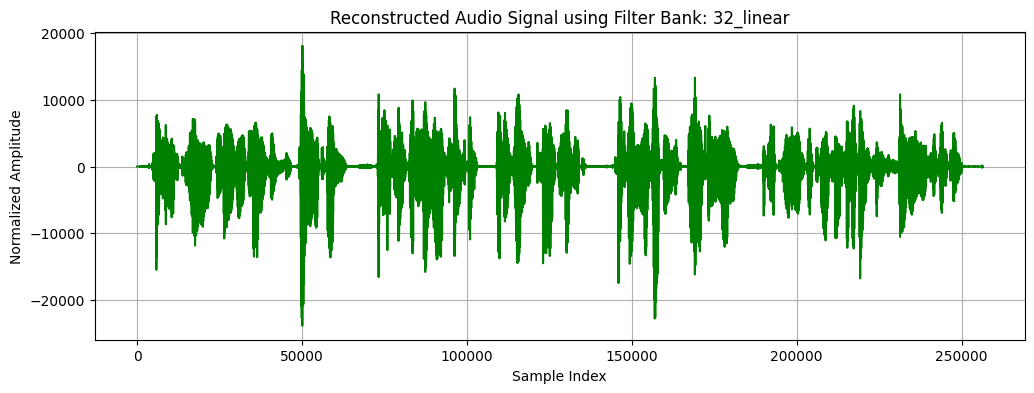

Applying filter bank: 32_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '32_log2' and file: male_3000_3000-15664-0020.wav


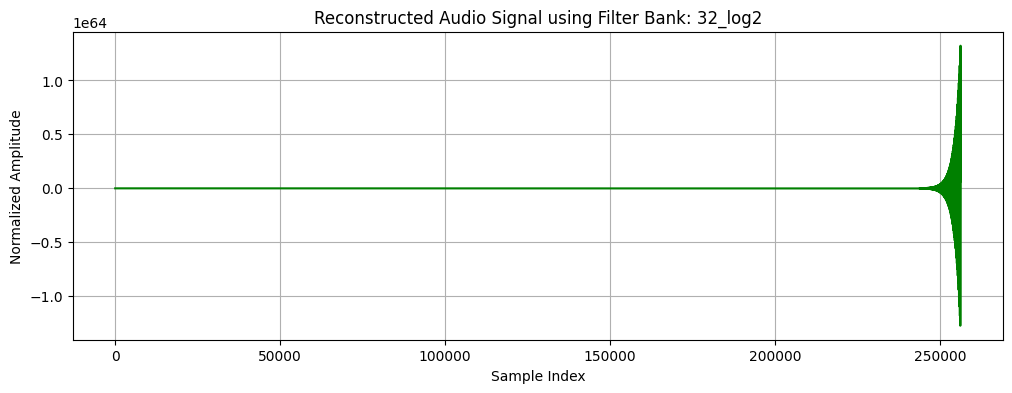

Applying filter bank: 32_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '32_log10' and file: male_3000_3000-15664-0020.wav


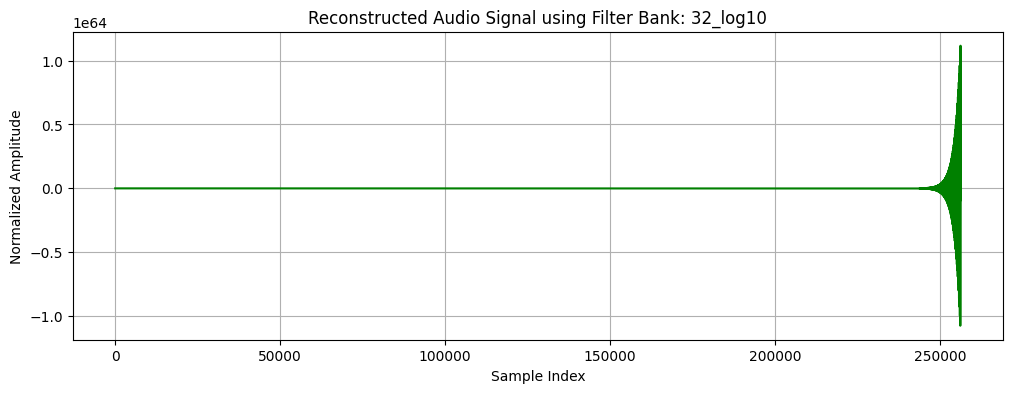

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/MaleFemaleAudio


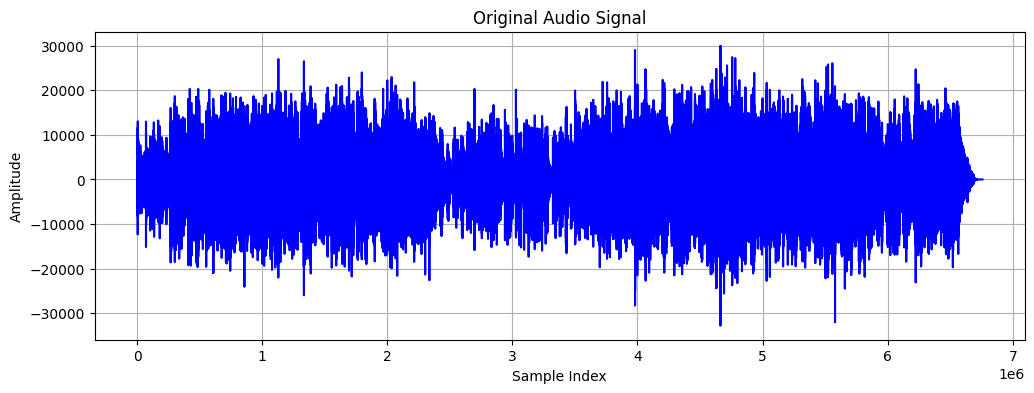

Applying filter bank: 8_linear to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '8_linear' and file: music-jamendo-0006.wav


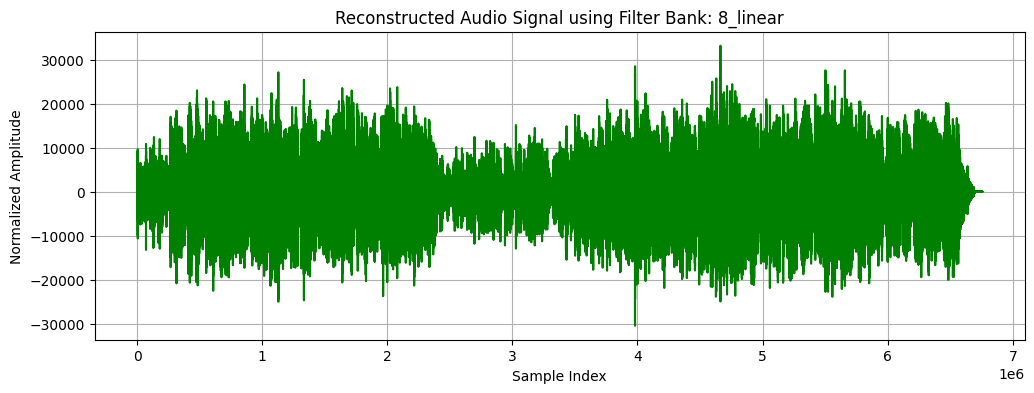

Applying filter bank: 8_log2 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '8_log2' and file: music-jamendo-0006.wav


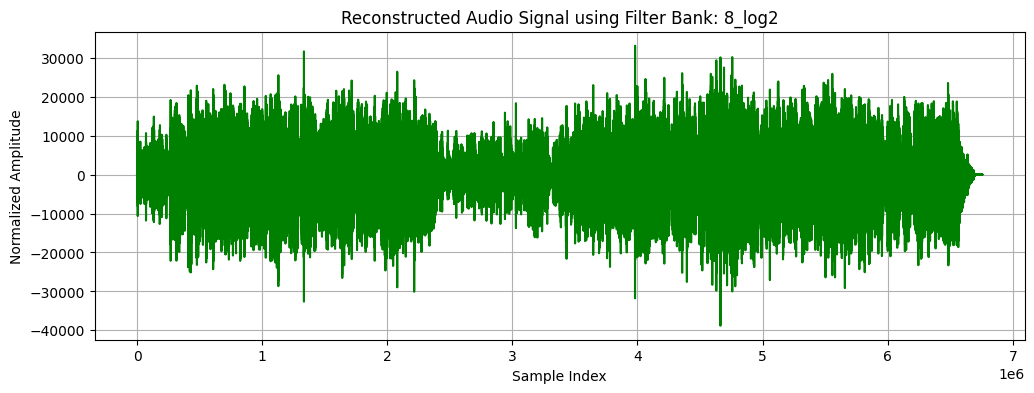

Applying filter bank: 8_log10 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '8_log10' and file: music-jamendo-0006.wav


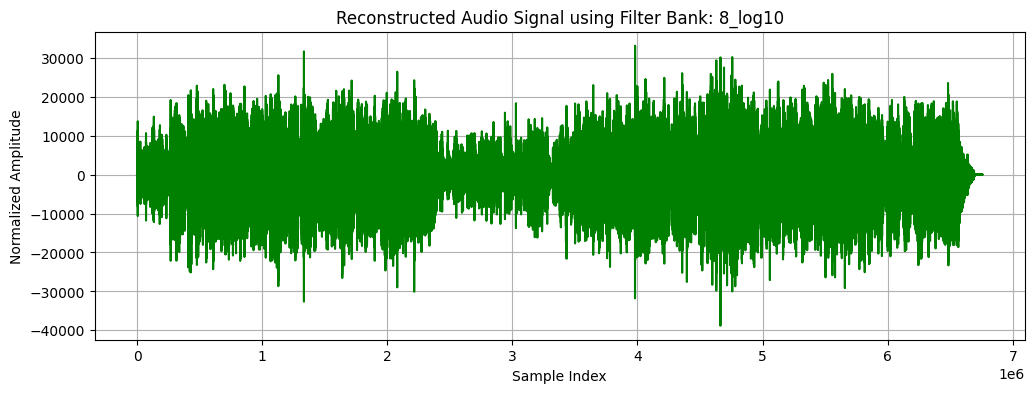

Applying filter bank: 16_linear to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '16_linear' and file: music-jamendo-0006.wav


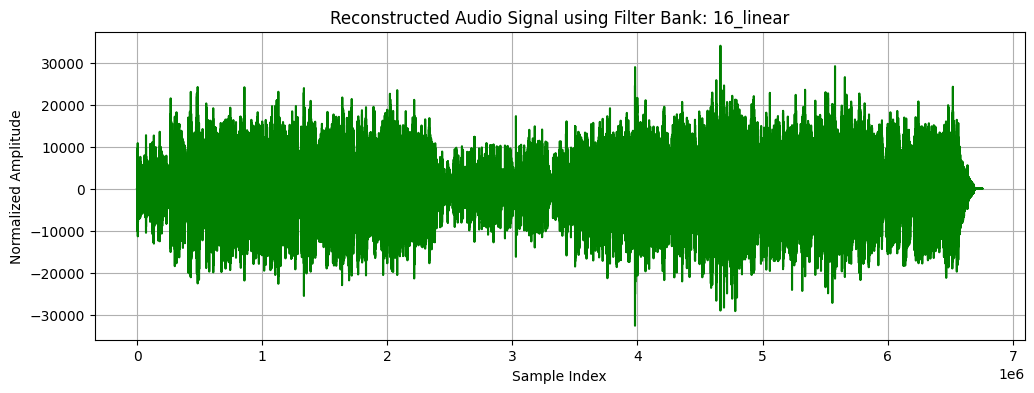

Applying filter bank: 16_log2 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '16_log2' and file: music-jamendo-0006.wav


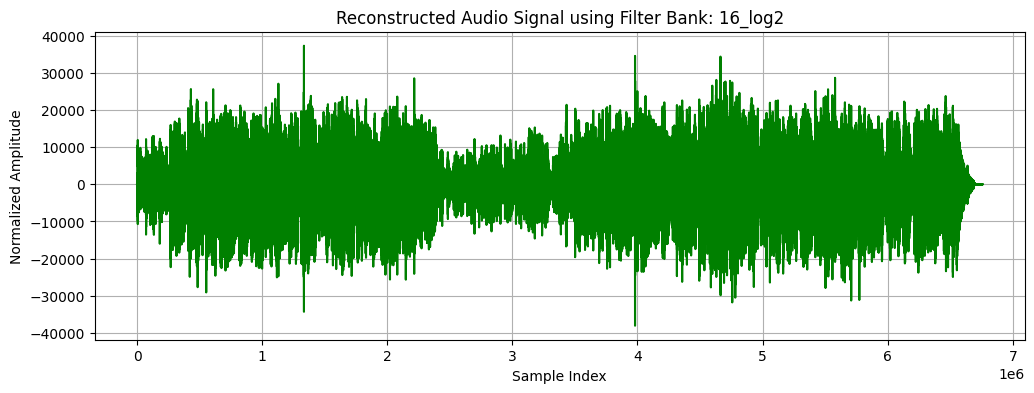

Applying filter bank: 16_log10 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '16_log10' and file: music-jamendo-0006.wav


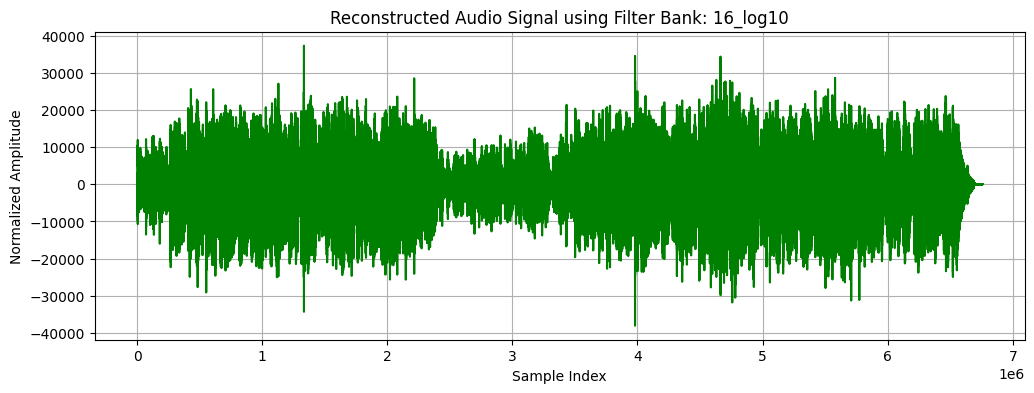

Applying filter bank: 32_linear to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '32_linear' and file: music-jamendo-0006.wav


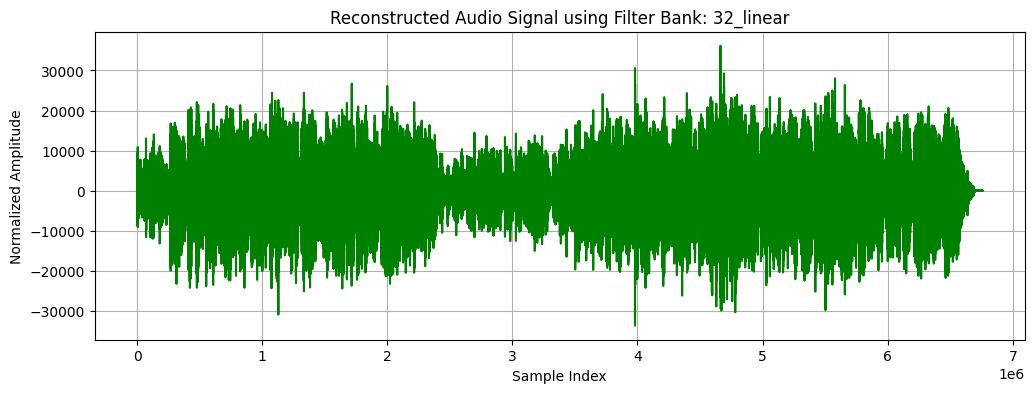

Applying filter bank: 32_log2 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '32_log2' and file: music-jamendo-0006.wav


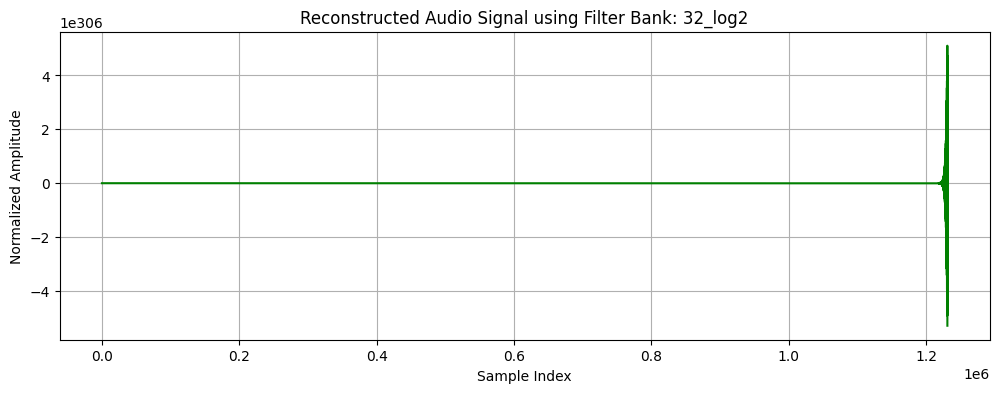

Applying filter bank: 32_log10 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '32_log10' and file: music-jamendo-0006.wav


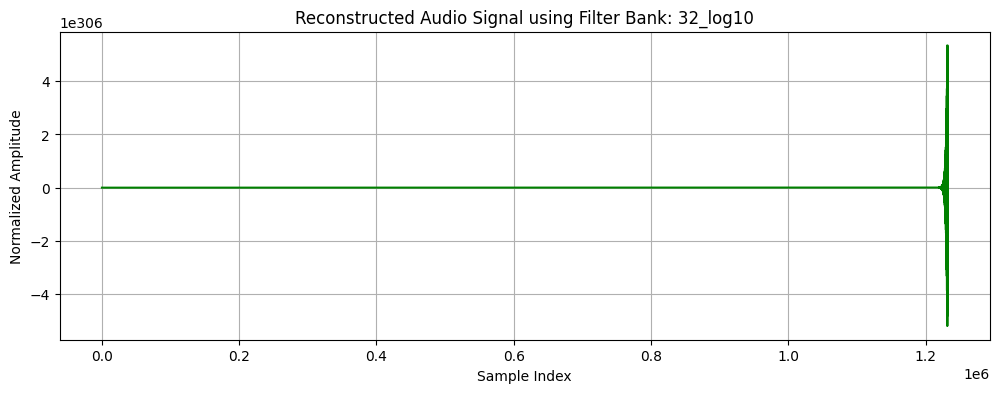

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/NoisyAudio


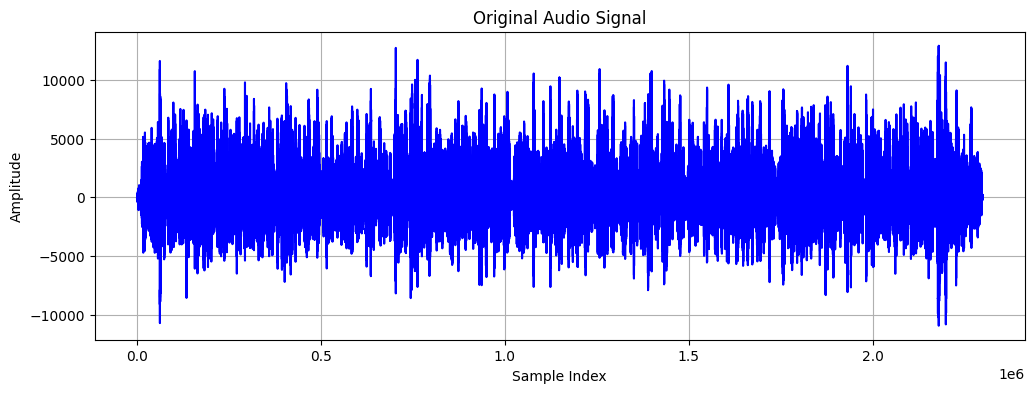

Applying filter bank: 8_linear to file: qsfzo.wav
Reconstructed Audio for filter bank '8_linear' and file: qsfzo.wav


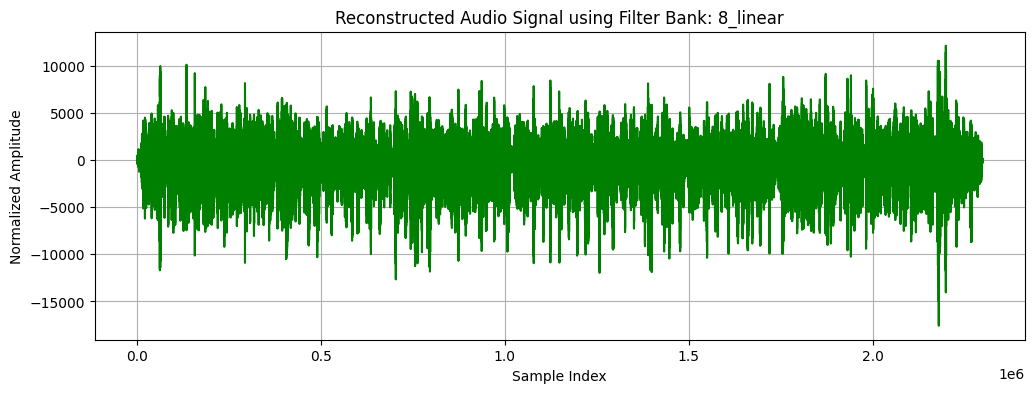

Applying filter bank: 8_log2 to file: qsfzo.wav
Reconstructed Audio for filter bank '8_log2' and file: qsfzo.wav


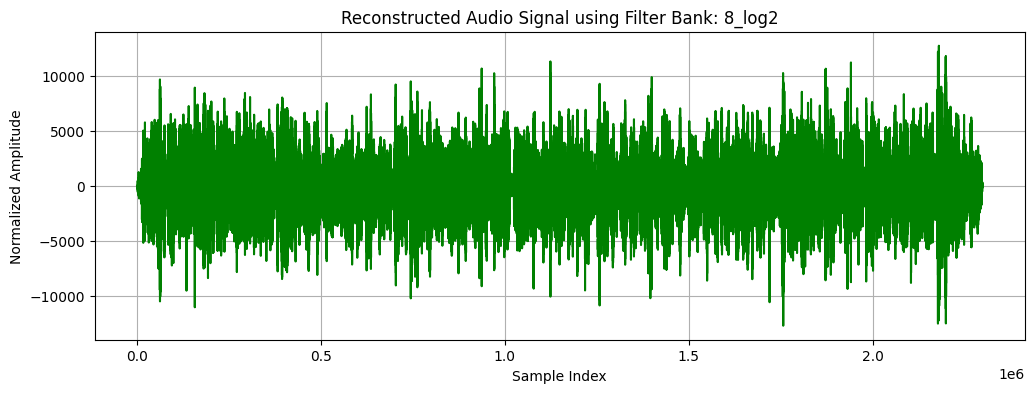

Applying filter bank: 8_log10 to file: qsfzo.wav
Reconstructed Audio for filter bank '8_log10' and file: qsfzo.wav


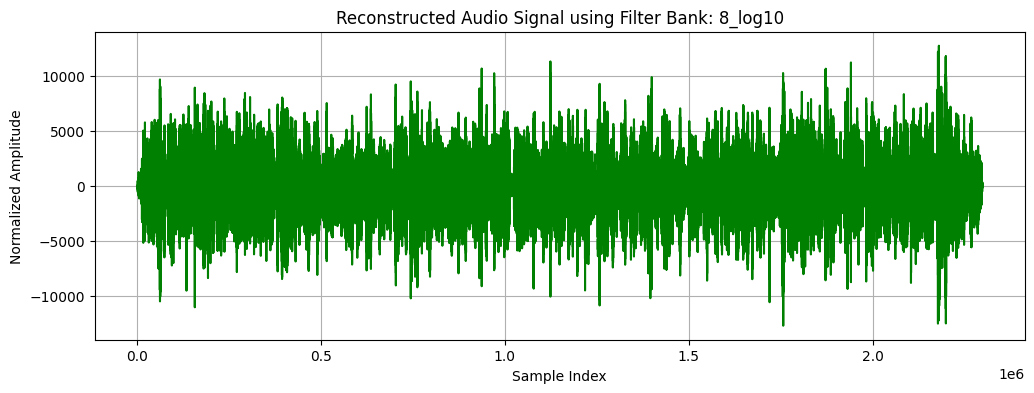

Applying filter bank: 16_linear to file: qsfzo.wav
Reconstructed Audio for filter bank '16_linear' and file: qsfzo.wav


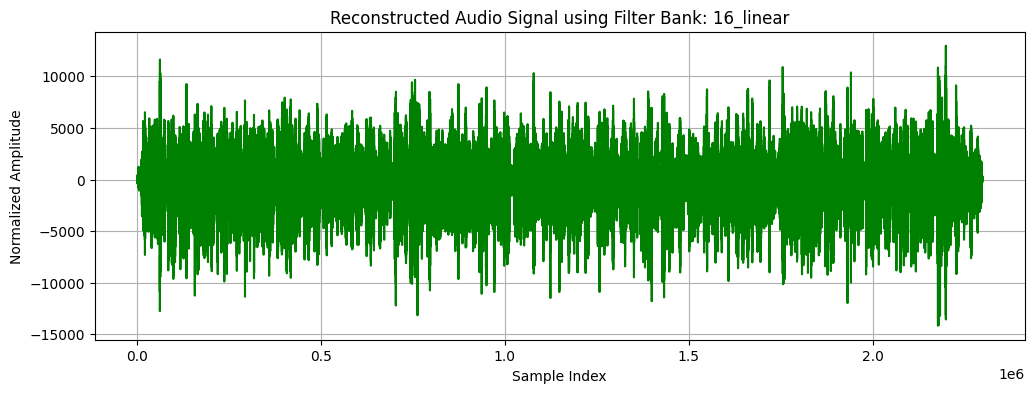

Applying filter bank: 16_log2 to file: qsfzo.wav
Reconstructed Audio for filter bank '16_log2' and file: qsfzo.wav


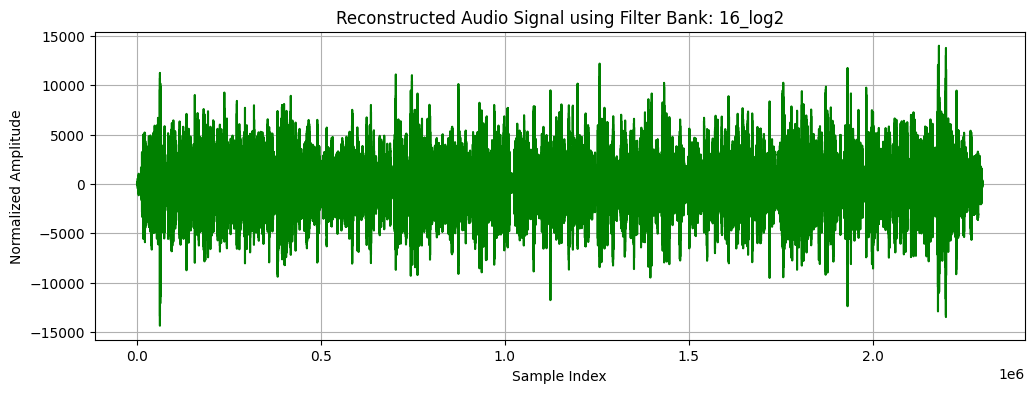

Applying filter bank: 16_log10 to file: qsfzo.wav
Reconstructed Audio for filter bank '16_log10' and file: qsfzo.wav


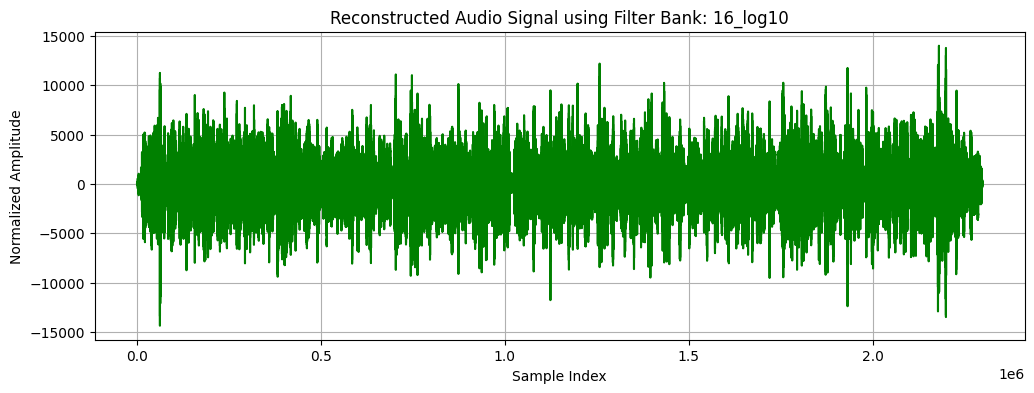

Applying filter bank: 32_linear to file: qsfzo.wav
Reconstructed Audio for filter bank '32_linear' and file: qsfzo.wav


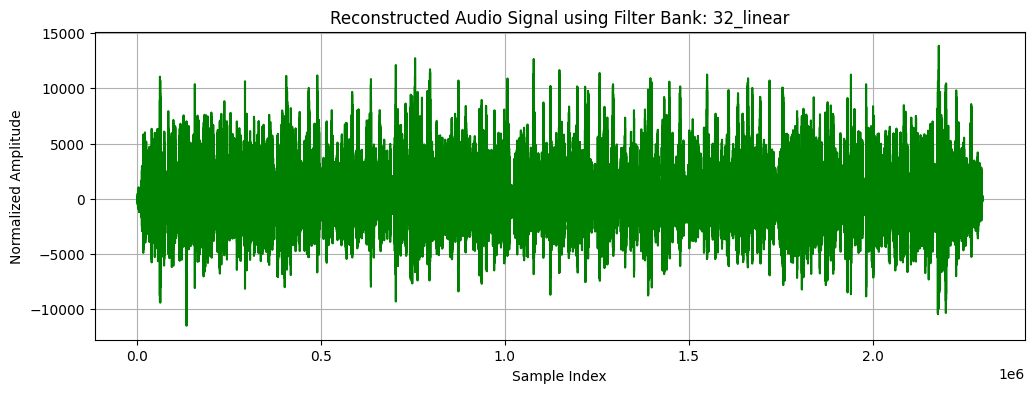

Applying filter bank: 32_log2 to file: qsfzo.wav
Reconstructed Audio for filter bank '32_log2' and file: qsfzo.wav


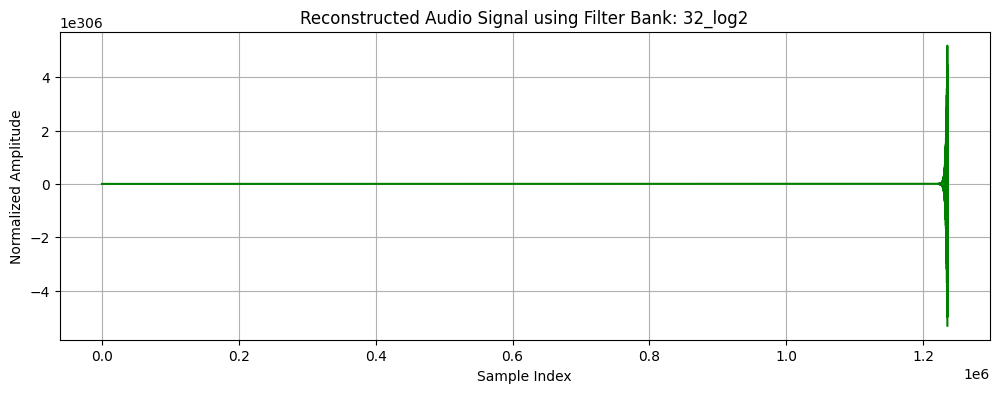

Applying filter bank: 32_log10 to file: qsfzo.wav
Reconstructed Audio for filter bank '32_log10' and file: qsfzo.wav


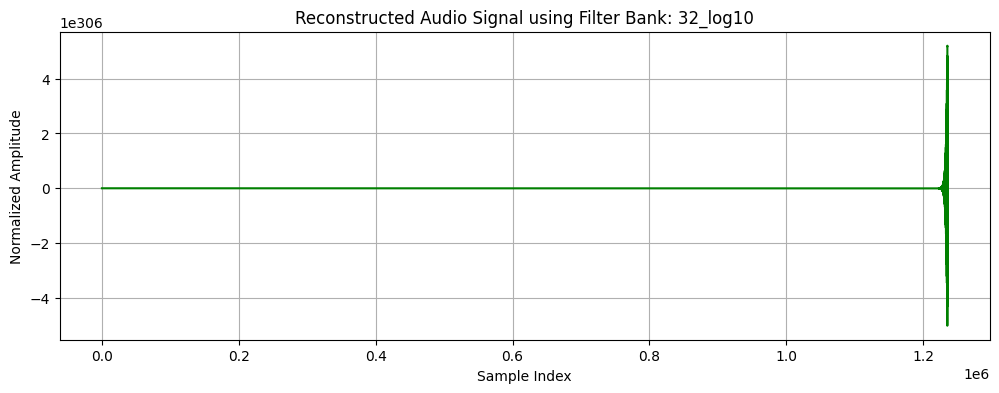

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/MultipleSpeakers


In [91]:
process_and_display_plot(cleaned_data_subdir_paths, butter_banks, max_files=0)

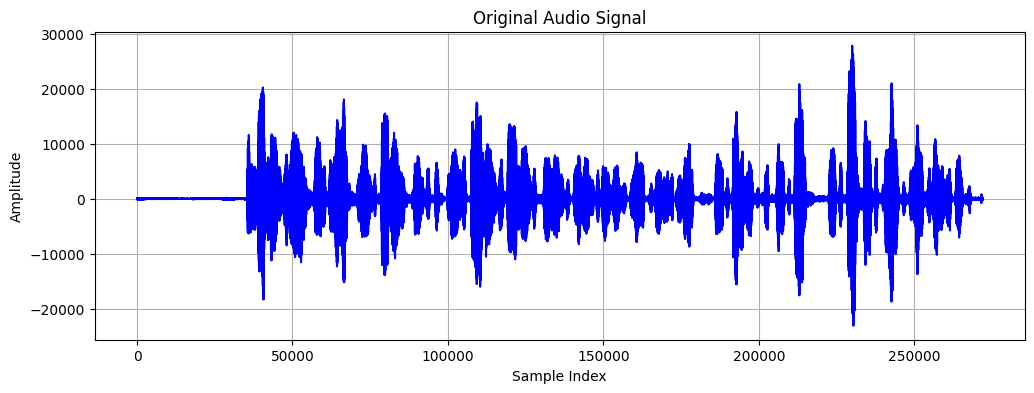

Applying filter bank: 8_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_linear' and file: F12_09_05.wav


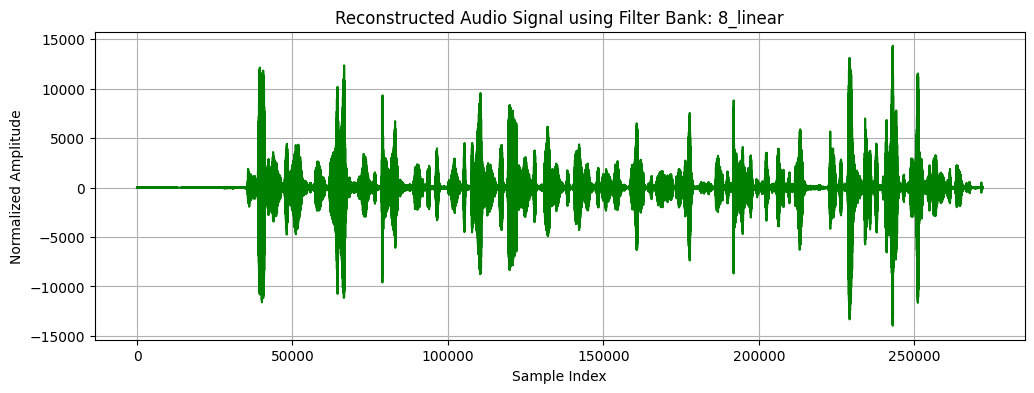

Applying filter bank: 8_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_log2' and file: F12_09_05.wav


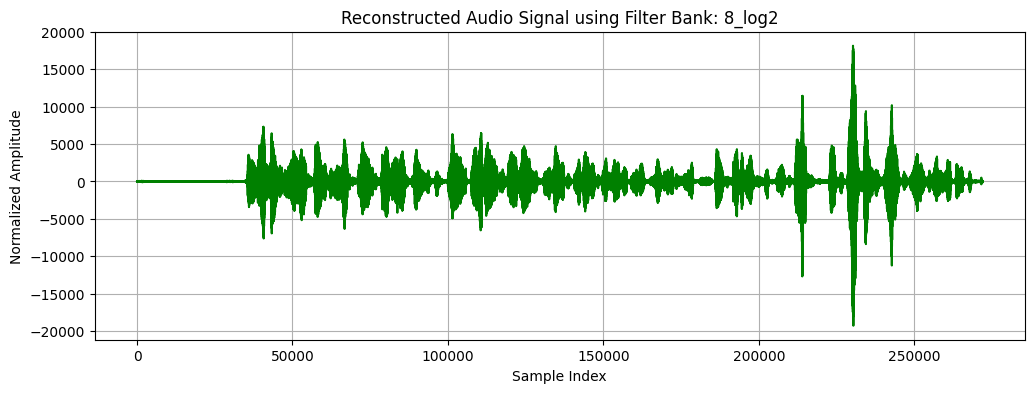

Applying filter bank: 8_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '8_log10' and file: F12_09_05.wav


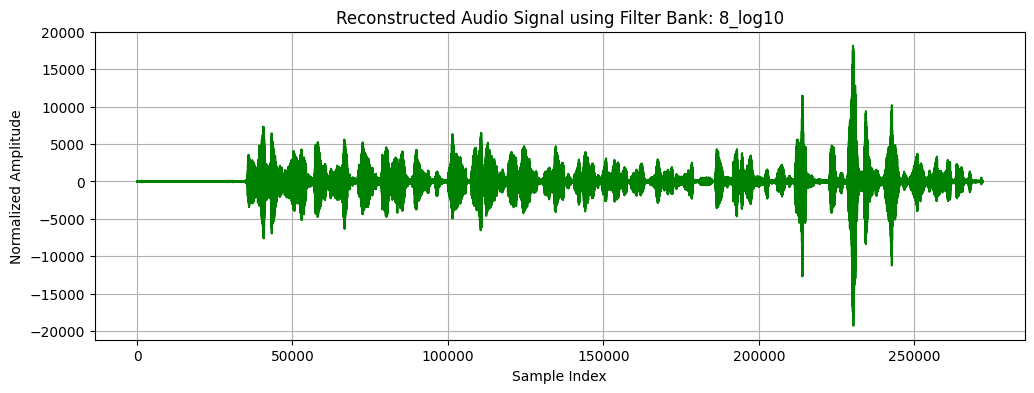

Applying filter bank: 16_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_linear' and file: F12_09_05.wav


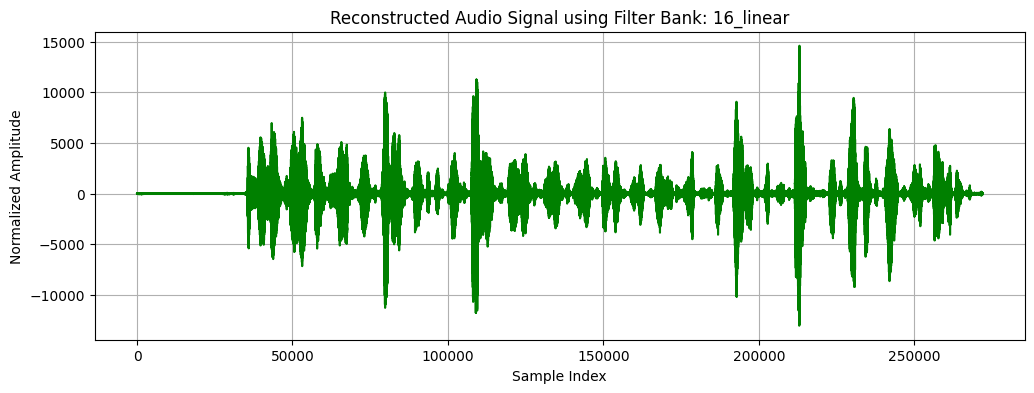

Applying filter bank: 16_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_log2' and file: F12_09_05.wav


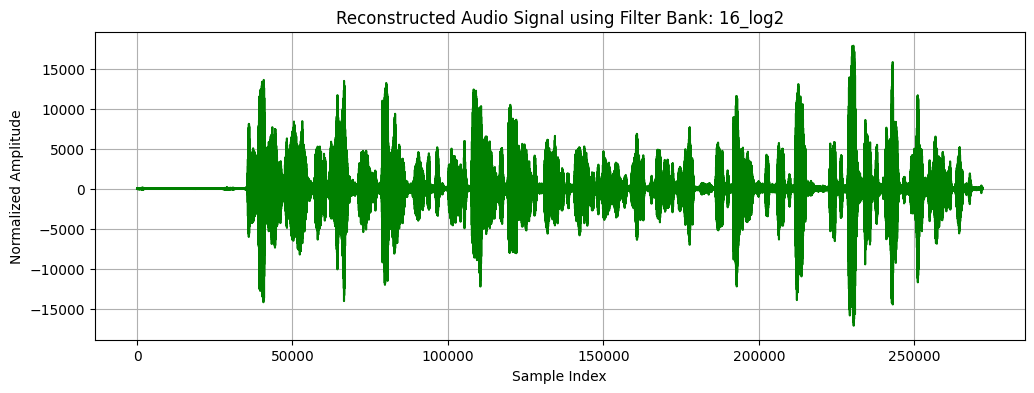

Applying filter bank: 16_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '16_log10' and file: F12_09_05.wav


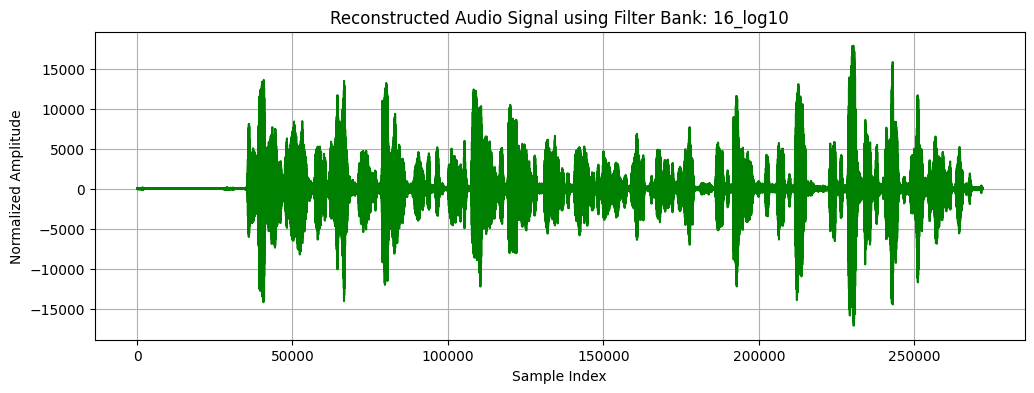

Applying filter bank: 32_linear to file: F12_09_05.wav
Reconstructed Audio for filter bank '32_linear' and file: F12_09_05.wav


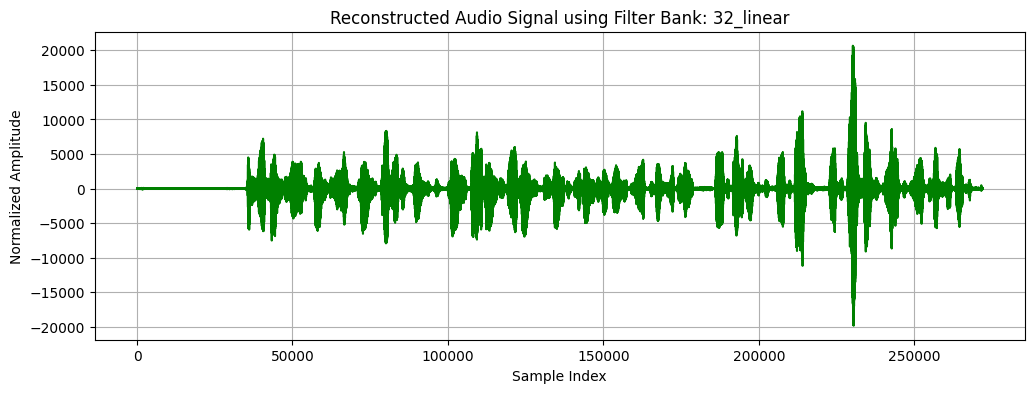

Applying filter bank: 32_log2 to file: F12_09_05.wav
Reconstructed Audio for filter bank '32_log2' and file: F12_09_05.wav


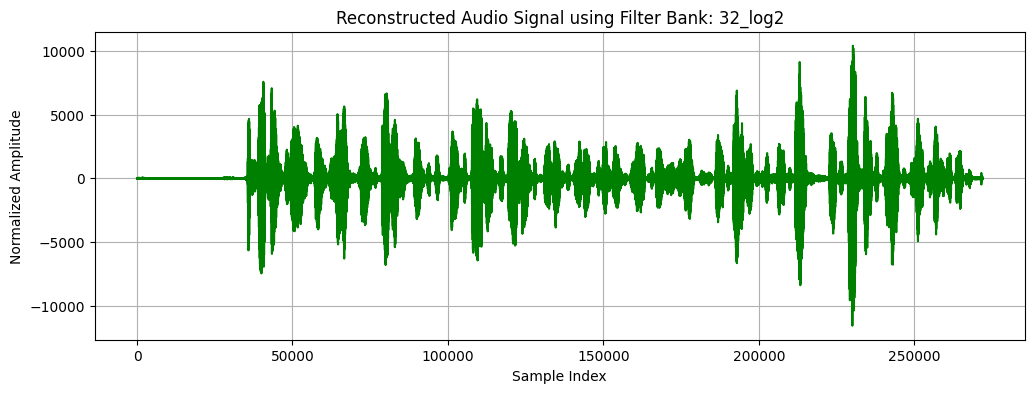

Applying filter bank: 32_log10 to file: F12_09_05.wav
Reconstructed Audio for filter bank '32_log10' and file: F12_09_05.wav


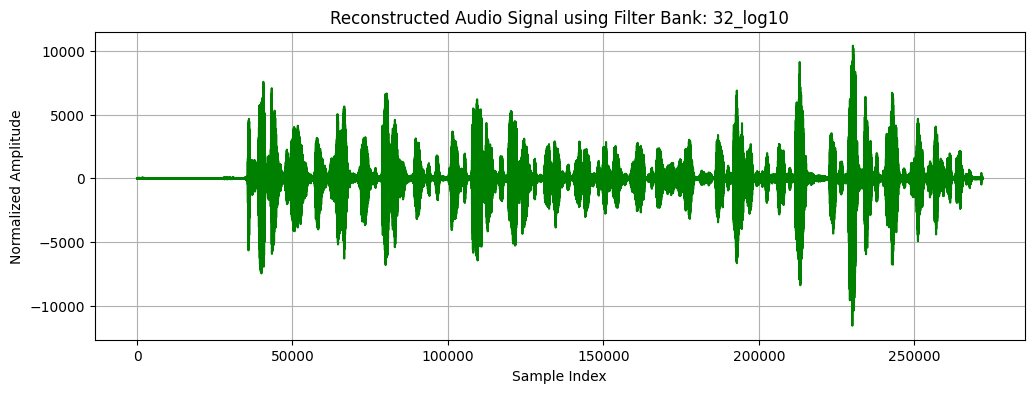

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/ChildrenAudio


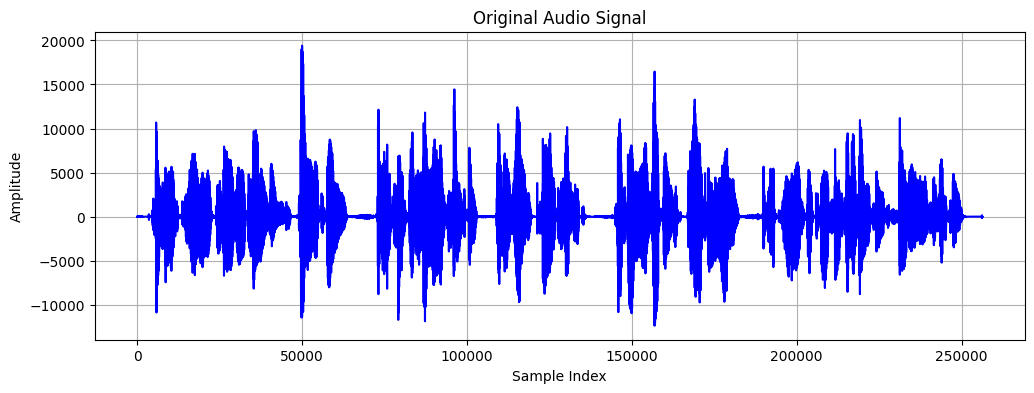

Applying filter bank: 8_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_linear' and file: male_3000_3000-15664-0020.wav


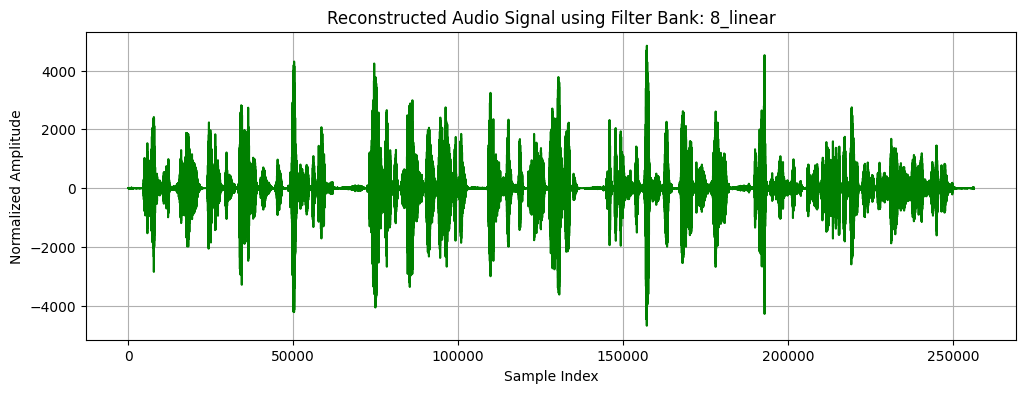

Applying filter bank: 8_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_log2' and file: male_3000_3000-15664-0020.wav


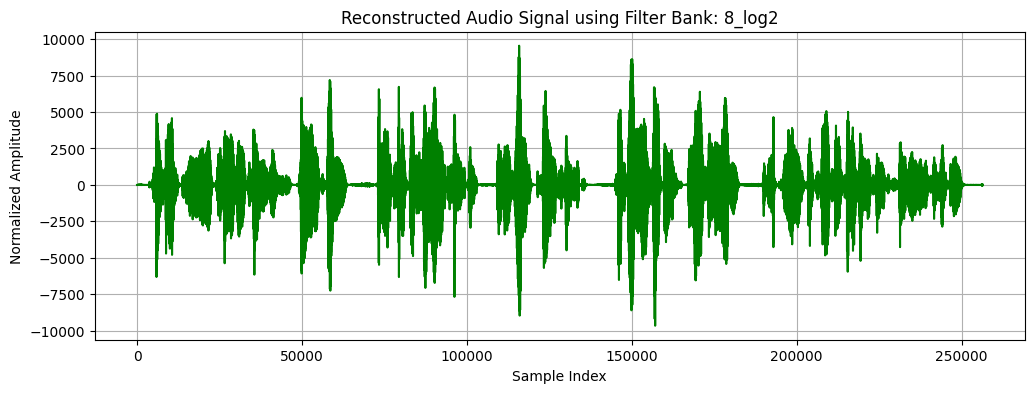

Applying filter bank: 8_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '8_log10' and file: male_3000_3000-15664-0020.wav


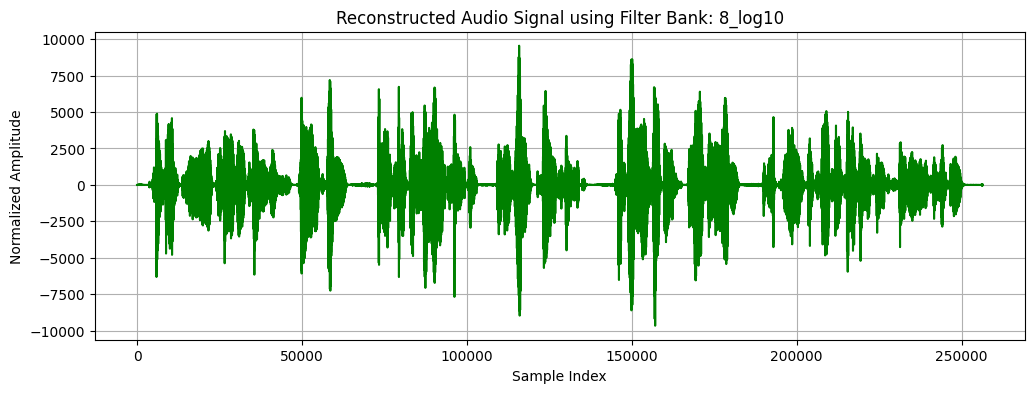

Applying filter bank: 16_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_linear' and file: male_3000_3000-15664-0020.wav


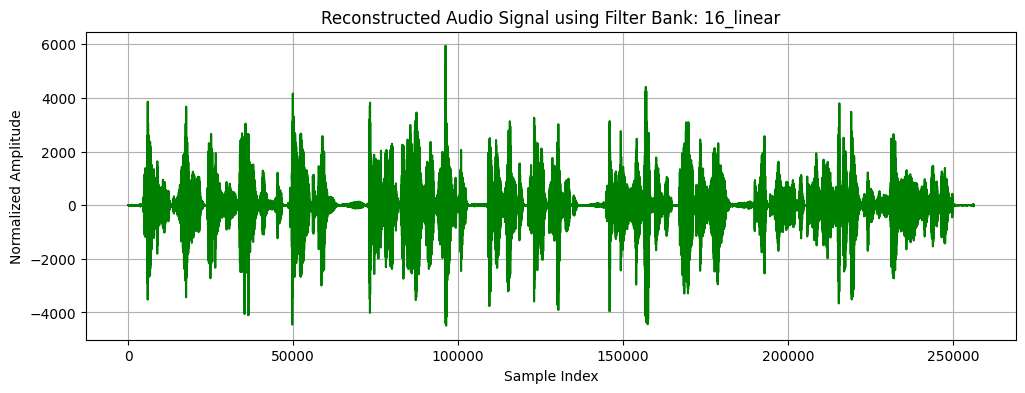

Applying filter bank: 16_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_log2' and file: male_3000_3000-15664-0020.wav


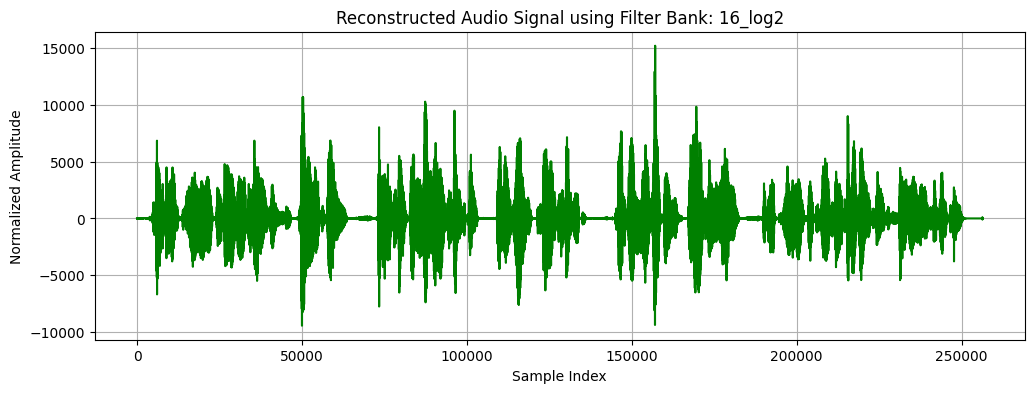

Applying filter bank: 16_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '16_log10' and file: male_3000_3000-15664-0020.wav


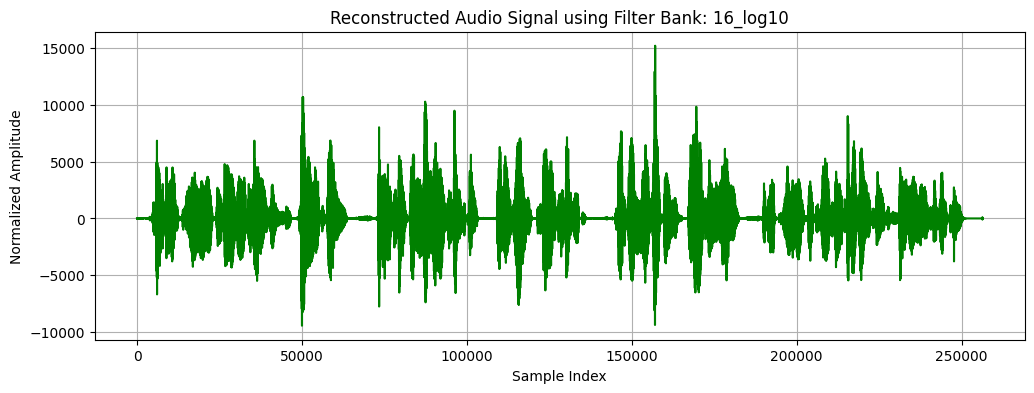

Applying filter bank: 32_linear to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '32_linear' and file: male_3000_3000-15664-0020.wav


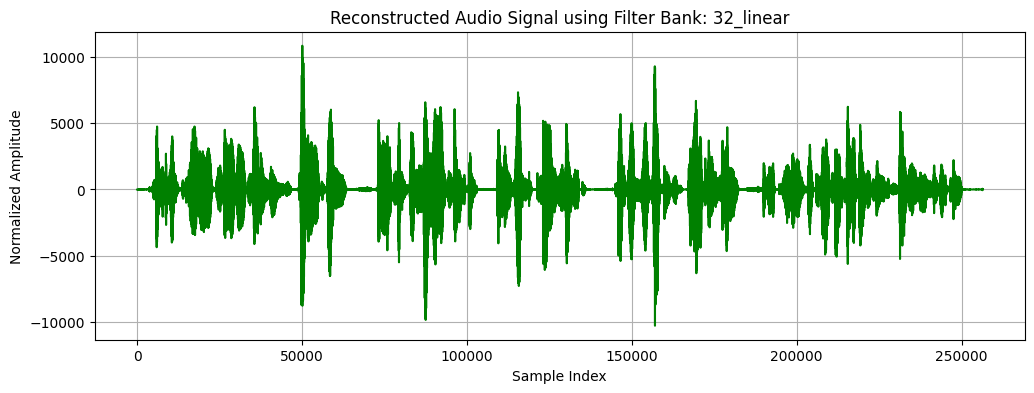

Applying filter bank: 32_log2 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '32_log2' and file: male_3000_3000-15664-0020.wav


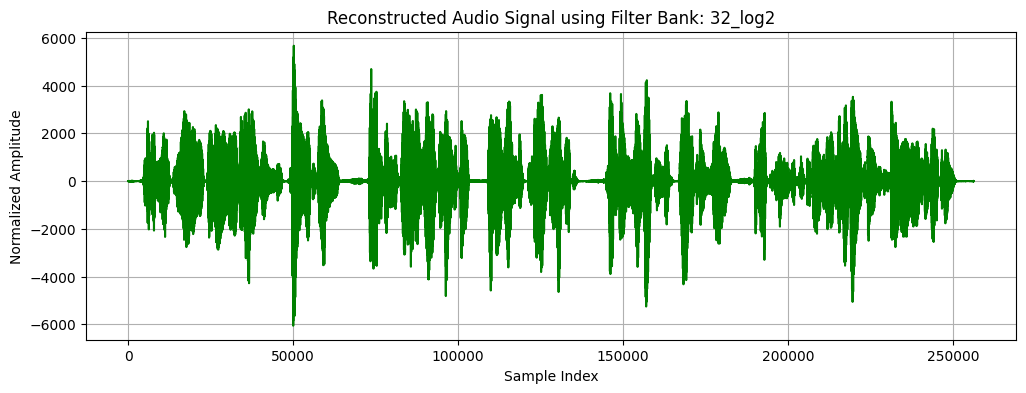

Applying filter bank: 32_log10 to file: male_3000_3000-15664-0020.wav
Reconstructed Audio for filter bank '32_log10' and file: male_3000_3000-15664-0020.wav


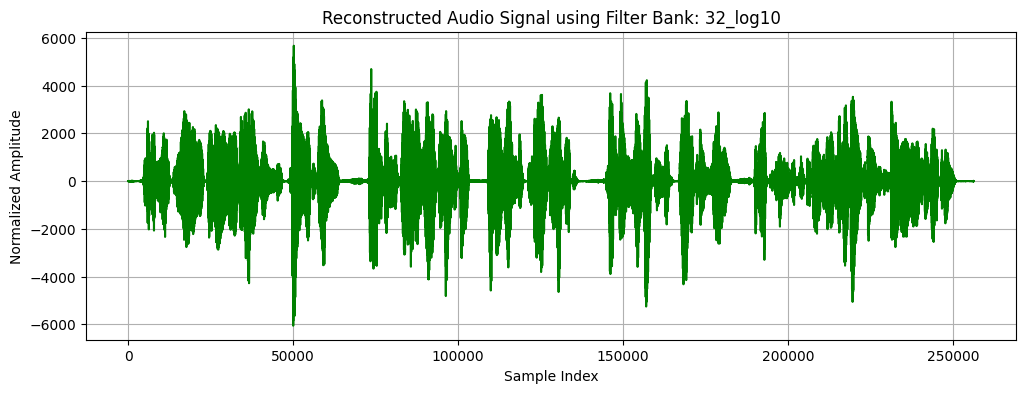

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/MaleFemaleAudio


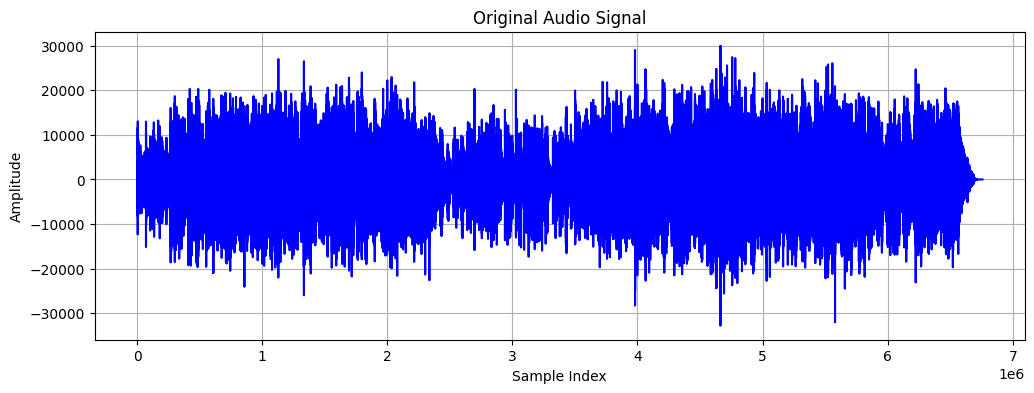

Applying filter bank: 8_linear to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '8_linear' and file: music-jamendo-0006.wav


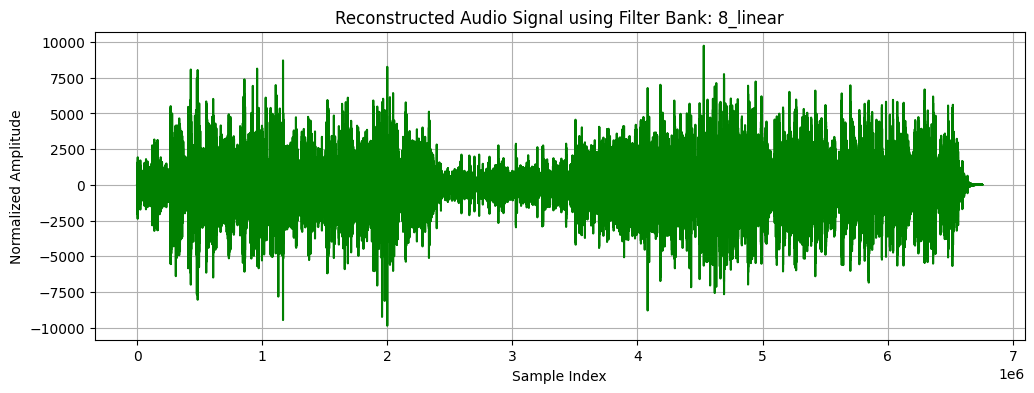

Applying filter bank: 8_log2 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '8_log2' and file: music-jamendo-0006.wav


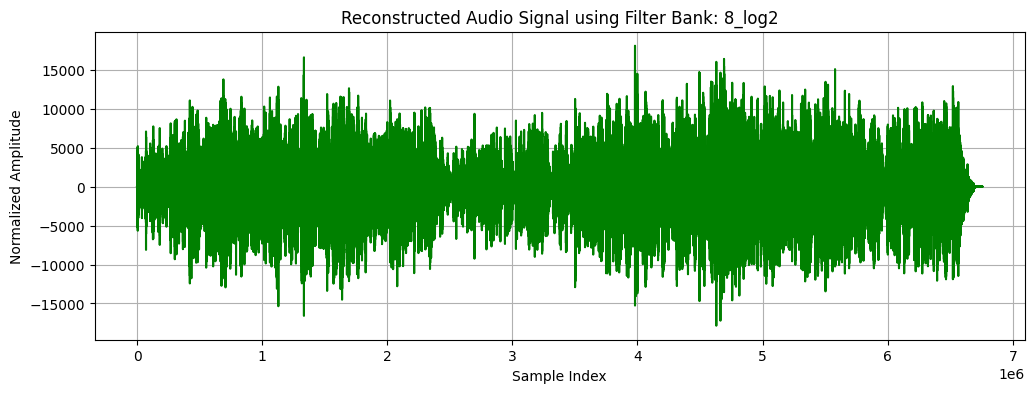

Applying filter bank: 8_log10 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '8_log10' and file: music-jamendo-0006.wav


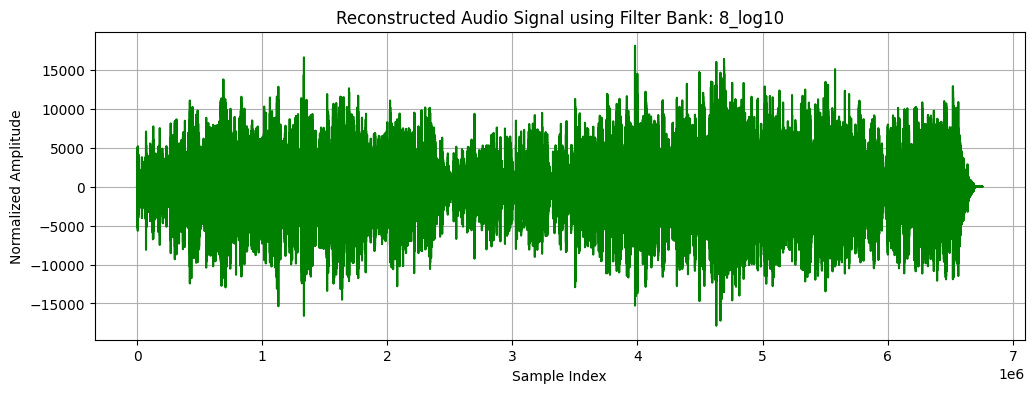

Applying filter bank: 16_linear to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '16_linear' and file: music-jamendo-0006.wav


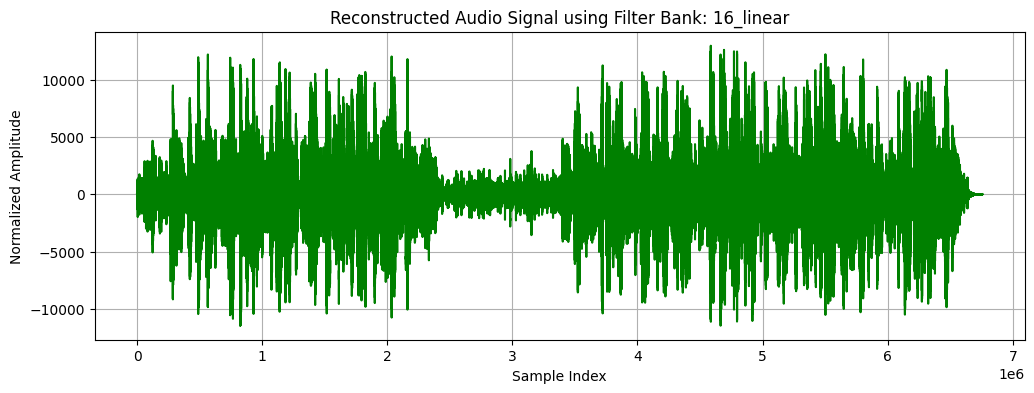

Applying filter bank: 16_log2 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '16_log2' and file: music-jamendo-0006.wav


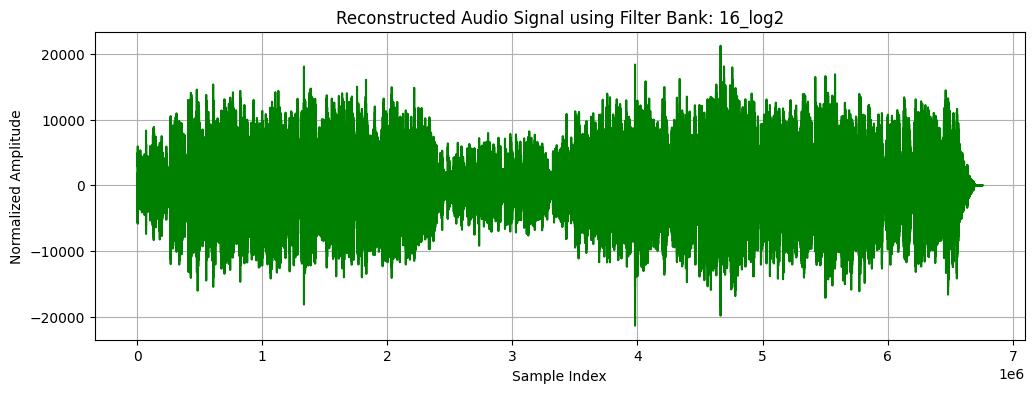

Applying filter bank: 16_log10 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '16_log10' and file: music-jamendo-0006.wav


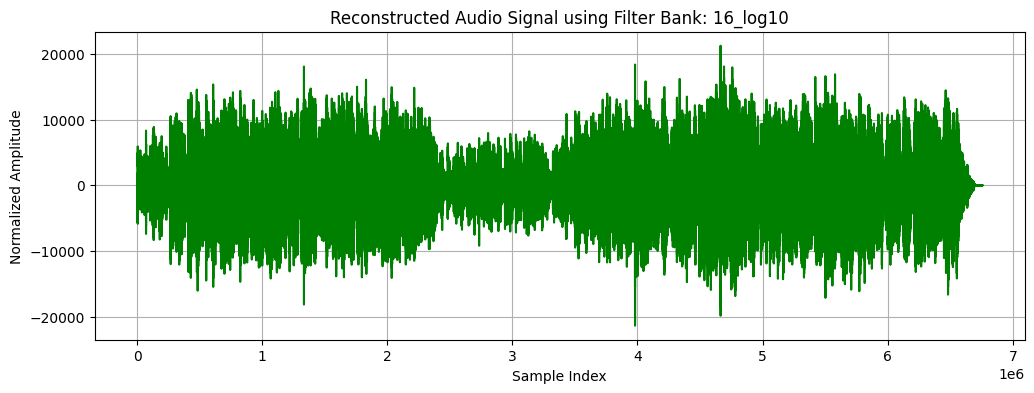

Applying filter bank: 32_linear to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '32_linear' and file: music-jamendo-0006.wav


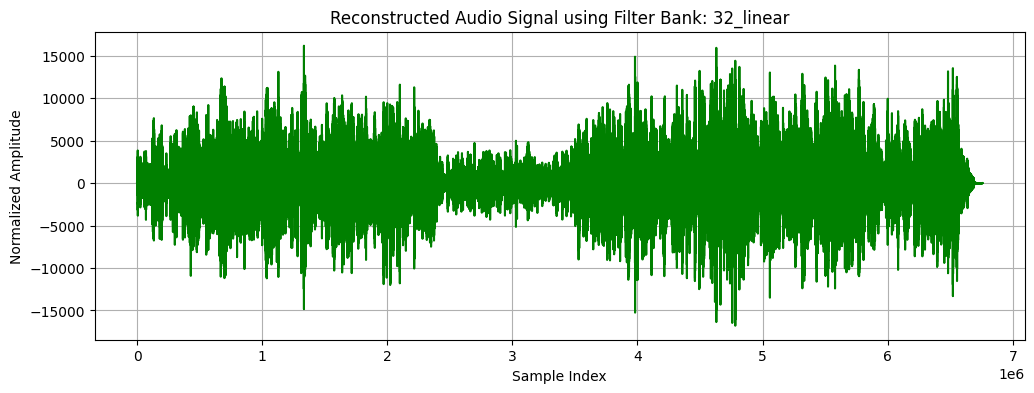

Applying filter bank: 32_log2 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '32_log2' and file: music-jamendo-0006.wav


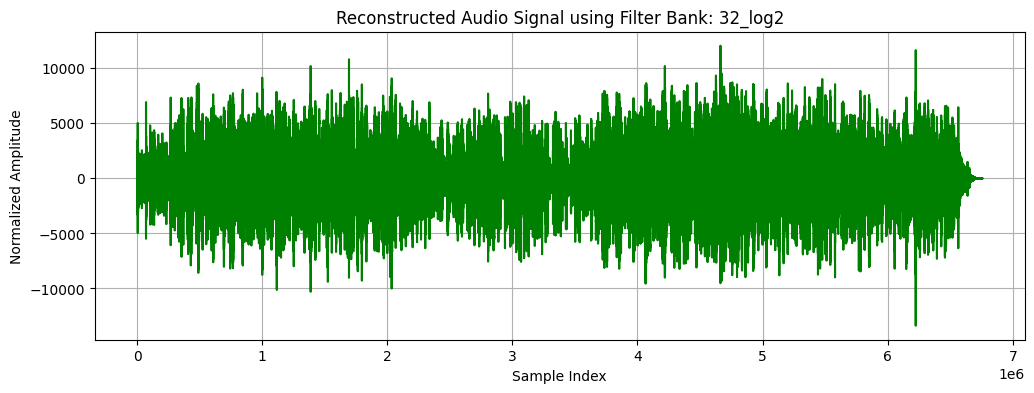

Applying filter bank: 32_log10 to file: music-jamendo-0006.wav
Reconstructed Audio for filter bank '32_log10' and file: music-jamendo-0006.wav


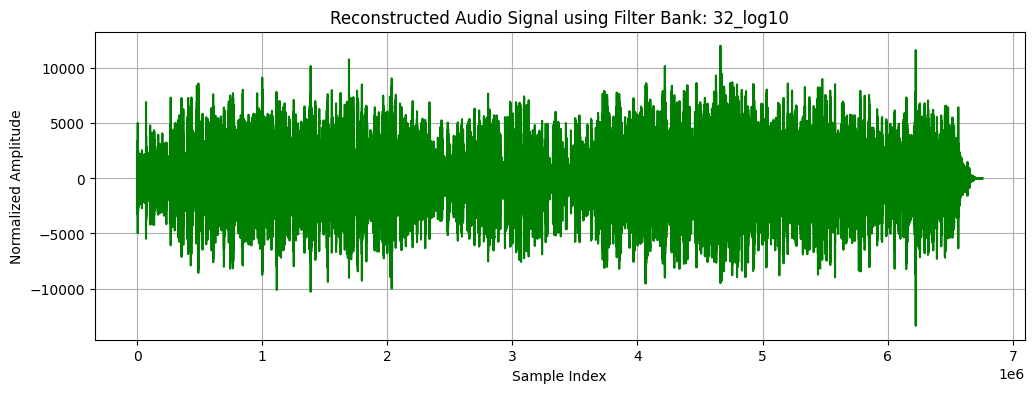

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/NoisyAudio


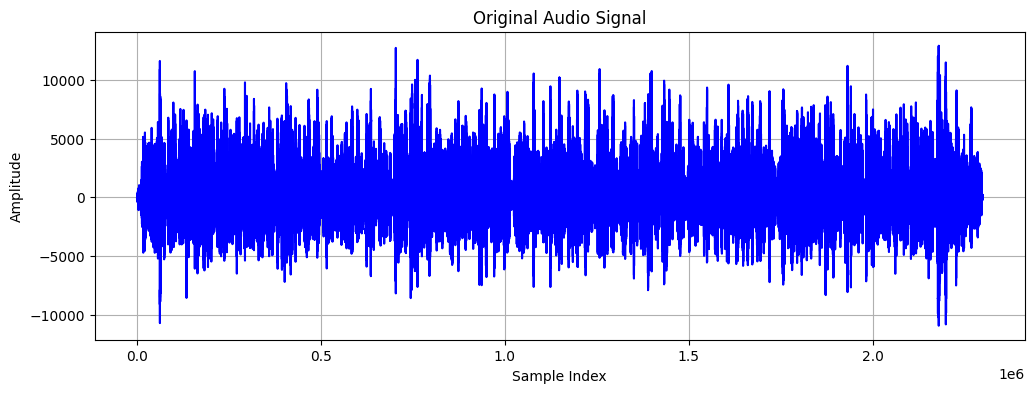

Applying filter bank: 8_linear to file: qsfzo.wav
Reconstructed Audio for filter bank '8_linear' and file: qsfzo.wav


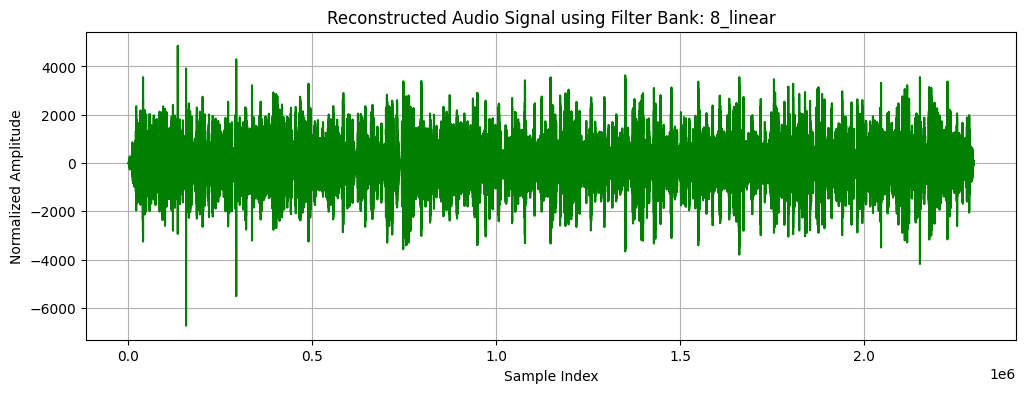

Applying filter bank: 8_log2 to file: qsfzo.wav
Reconstructed Audio for filter bank '8_log2' and file: qsfzo.wav


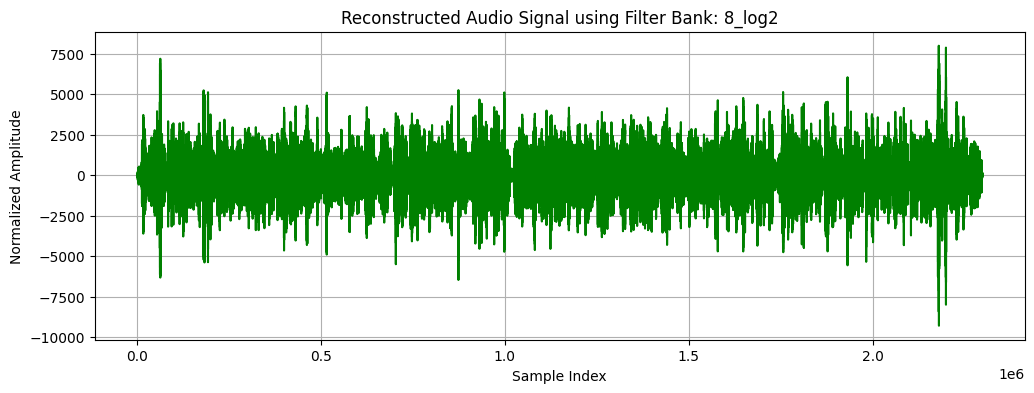

Applying filter bank: 8_log10 to file: qsfzo.wav
Reconstructed Audio for filter bank '8_log10' and file: qsfzo.wav


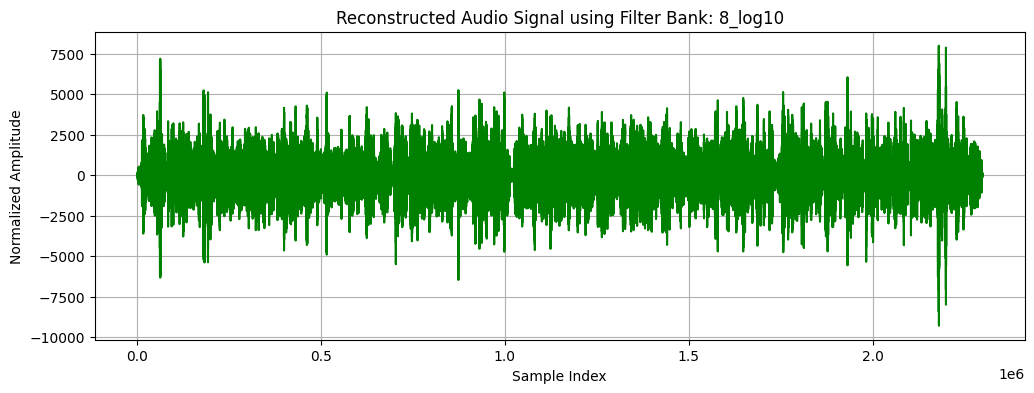

Applying filter bank: 16_linear to file: qsfzo.wav
Reconstructed Audio for filter bank '16_linear' and file: qsfzo.wav


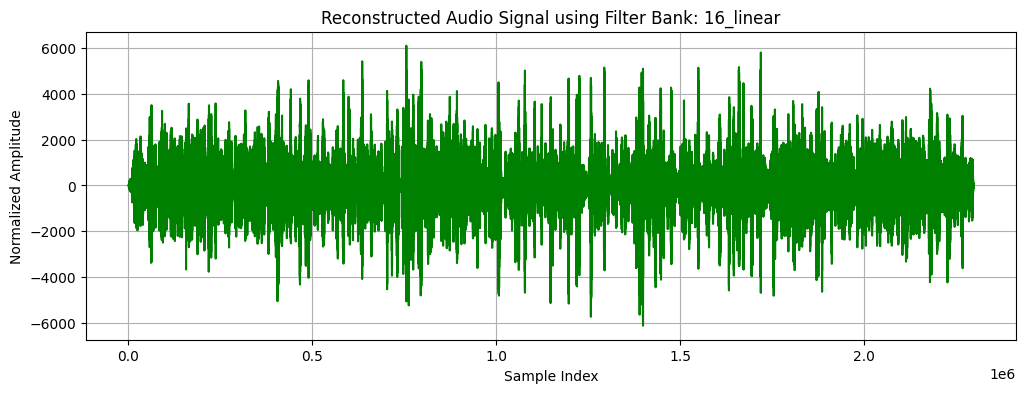

Applying filter bank: 16_log2 to file: qsfzo.wav
Reconstructed Audio for filter bank '16_log2' and file: qsfzo.wav


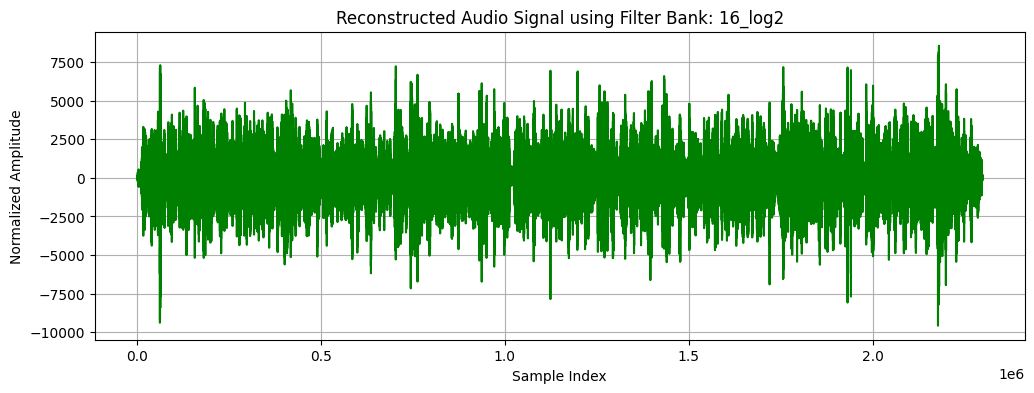

Applying filter bank: 16_log10 to file: qsfzo.wav
Reconstructed Audio for filter bank '16_log10' and file: qsfzo.wav


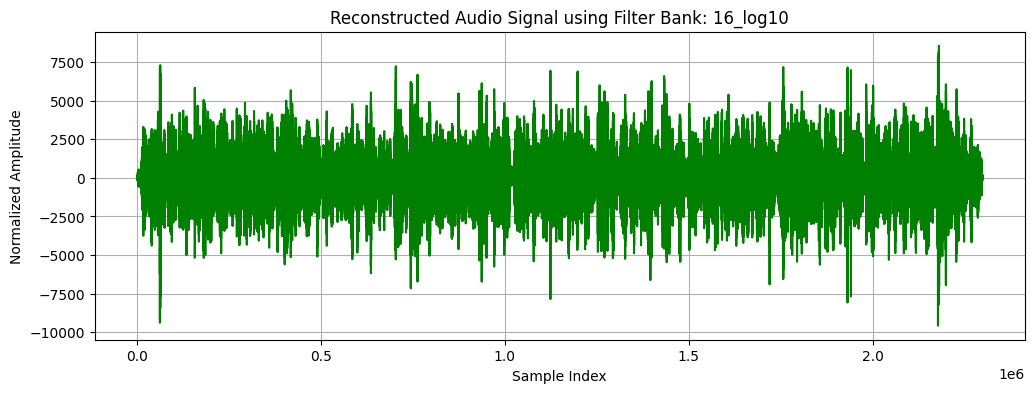

Applying filter bank: 32_linear to file: qsfzo.wav
Reconstructed Audio for filter bank '32_linear' and file: qsfzo.wav


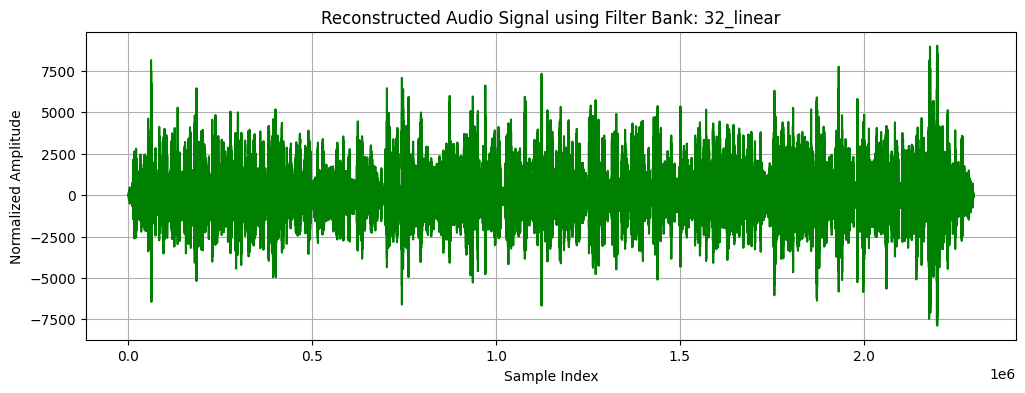

Applying filter bank: 32_log2 to file: qsfzo.wav
Reconstructed Audio for filter bank '32_log2' and file: qsfzo.wav


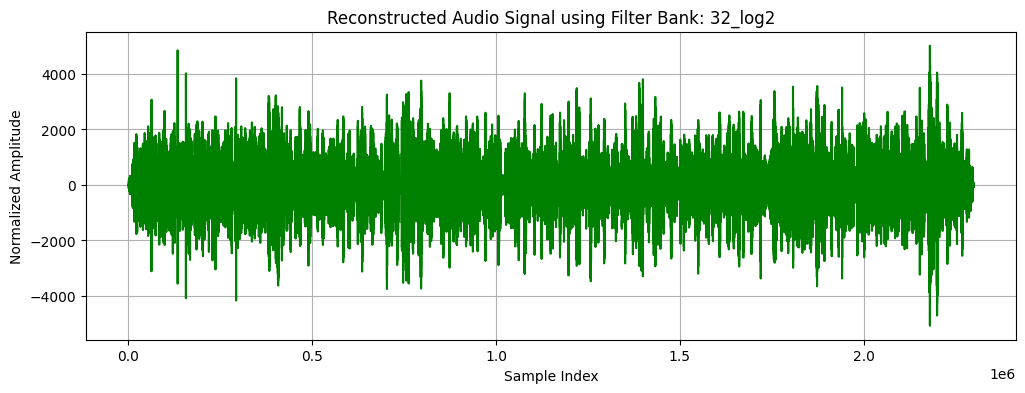

Applying filter bank: 32_log10 to file: qsfzo.wav
Reconstructed Audio for filter bank '32_log10' and file: qsfzo.wav


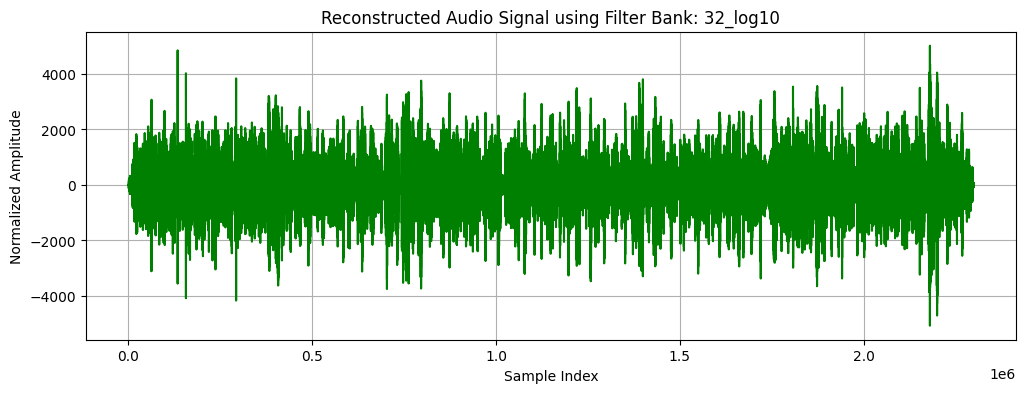

Processed 1 audio files from /Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/MultipleSpeakers


In [92]:
process_and_display_plot(cleaned_data_subdir_paths, gamma_banks, max_files=0)